<center><img src="https://raw.githubusercontent.com/mateuszk098/kaggle_notebooks/master/playground_series_s3e26/undraw_screen_time_vkev.png" width=400px></center>

# <p style="font-family: 'JetBrains Mono'; font-weight: bold; font-size: 125%; color: #4A4B52; text-align: center">Playground Series S3E26 - Cirrhosis Outcomes</p>

<center>
<table style="
  padding: 10px;
  font-family: 'JetBrains Mono';
  font-size: 16px;
  width: 100%";
>
  <tr>
    <th>Version</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>V1</td>
    <td>Quick Overview</td>
  </tr>
  <tr>
    <td>V2</td>
    <td>Unsupervised Learning - Dimensionality Reduction</td>
  </tr>
  <tr>
    <td>V3</td>
    <td>Unsupervised Learning - Clustering</td>
  </tr>
  <tr>
    <td>V4</td>
    <td>Pipelines &amp; Optuna Tuning</td>
  </tr>
</table>
</center>

In [1]:
# %load ../utils/config.py
# !pip install -q kaleido
import collections
import functools
import glob
import itertools
import operator
import os
import pathlib
import reprlib
import shutil
import subprocess
import sys
import time
import warnings
from array import array
from copy import copy

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.io as pio
import scipy.stats as stats
import seaborn as sns
import shap
from colorama import Fore, Style
from IPython.display import HTML, Image, display_html
from lightgbm import LGBMClassifier, early_stopping
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from sklearn import clone
from sklearn.base import (
    BaseEstimator,
    ClassNamePrefixFeaturesOutMixin,
    MetaEstimatorMixin,
    OneToOneFeatureMixin,
    TransformerMixin,
)
from sklearn.calibration import LabelEncoder, cross_val_predict
from sklearn.cluster import KMeans
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE, Isomap
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    log_loss,
    roc_auc_score,
    roc_curve,
)
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import FunctionTransformer, make_pipeline, make_union
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    StandardScaler,
)
from sklearn.random_projection import GaussianRandomProjection
from sklearn.utils.validation import check_array, check_is_fitted
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping

# Environment
ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None

# Colorama settings.
CLR = (Style.BRIGHT + Fore.BLACK) if ON_KAGGLE else (Style.BRIGHT + Fore.WHITE)
RED = Style.BRIGHT + Fore.RED
BLUE = Style.BRIGHT + Fore.BLUE
CYAN = Style.BRIGHT + Fore.CYAN
MAGENTA = Style.BRIGHT + Fore.MAGENTA
RESET = Style.RESET_ALL

# Data Frame and Plotly colors.
FONT_COLOR = "#4A4B52"
BACKGROUND_COLOR = "#FFFCFA"
GRADIENT_COLOR = "#BAB8B8"
# Define as numpy array because it supports fancy indexing.
COLOR_SCHEME = np.array(("#4A4B52", "#421D4F", "#B3B3B8", "#FCFCFC"))
# Ticks size for plotly and matplotlib.
TICKSIZE = 11

# Set Plotly theme.
pio.templates["minimalist"] = go.layout.Template(
    layout=go.Layout(
        font_family="Open Sans",
        font_color=FONT_COLOR,
        title_font_size=20,
        plot_bgcolor=BACKGROUND_COLOR,
        paper_bgcolor=BACKGROUND_COLOR,
        xaxis=dict(tickfont_size=TICKSIZE, titlefont_size=TICKSIZE, showgrid=False),
        yaxis=dict(tickfont_size=TICKSIZE, titlefont_size=TICKSIZE, showgrid=False),
        width=840,
        height=540,
        legend=dict(x=1, y=1, yanchor="bottom", xanchor="right", orientation="h", title=""),
    ),
    layout_colorway=COLOR_SCHEME,
)
pio.templates.default = "plotly+minimalist"

MATPLOTLIB_THEME = {
    "axes.labelcolor": FONT_COLOR,
    "axes.labelsize": TICKSIZE,
    "axes.facecolor": BACKGROUND_COLOR,
    "axes.titlesize": 14,
    "axes.grid": False,
    "xtick.labelsize": TICKSIZE,
    "xtick.color": FONT_COLOR,
    "ytick.labelsize": TICKSIZE,
    "ytick.color": FONT_COLOR,
    "figure.facecolor": BACKGROUND_COLOR,
    "figure.edgecolor": BACKGROUND_COLOR,
    "figure.titlesize": 14,
    "figure.dpi": 72,  # Locally Seaborn uses 72, meanwhile Kaggle 96.
    "text.color": FONT_COLOR,
    "font.size": TICKSIZE,
    "font.family": "Serif",
}
sns.set_theme(rc=MATPLOTLIB_THEME)

# Define Data Frame theme.
CELL_HOVER = {  # for row hover use <tr> instead of <td>
    "selector": "td:hover",
    "props": f"background-color: {BACKGROUND_COLOR}",
}
TEXT_HIGHLIGHT = {
    "selector": "td",
    "props": f"color: {FONT_COLOR}; font-weight: bold",
}
INDEX_NAMES = {
    "selector": ".index_name",
    "props": f"font-weight: normal; background-color: {BACKGROUND_COLOR}; color: {FONT_COLOR};",
}
HEADERS = {
    "selector": "th:not(.index_name)",
    "props": f"font-weight: normal; background-color: {BACKGROUND_COLOR}; color: {FONT_COLOR};",
}
DF_STYLE = (INDEX_NAMES, HEADERS, TEXT_HIGHLIGHT)
DF_CMAP = sns.light_palette(GRADIENT_COLOR, as_cmap=True)

# Html style for table of contents, code highlight and url.
HTML_STYLE = """
    <style>
    code {
        background: rgba(42, 53, 125, 0.10) !important;
        border-radius: 4px !important;
    }
    a {
        color: rgba(123, 171, 237, 1.0) !important;
    }
    ol.numbered-list {
        counter-reset: item;
    }
    ol.numbered-list li {
        display: block;
    }
    ol.numbered-list li:before {
        content: counters(item, '.') '. ';
        counter-increment: item;
    }
    </style>
"""


# Utility functions.
def download_from_kaggle(expr, /, data_dir=None):
    """Download all files from the Kaggle competition/dataset.

    Args:
        expr: Match expression to be used by kaggle API, e.g.
            "kaggle competitions download -c competition" or
            "kaggle datasets download -d user/dataset".
        data_dir: Optional. Directory path where to save files. Default to `None`,
        which means that files will be downloaded to `data` directory.

    Notes:
        If the associated files already exists, then it does nothing.
    """

    if data_dir is None:
        data_dir = pathlib.Path("data/")
    else:
        data_dir = pathlib.Path(data_dir)

    match expr.split():
        case ["kaggle", _, "download", *args] if args:
            data_dir.mkdir(parents=True, exist_ok=True)
            filename = args[-1].split("/")[-1] + ".zip"
            if not (data_dir / filename).is_file():
                subprocess.run(expr)
                shutil.unpack_archive(filename, data_dir)
                shutil.move(filename, data_dir)
        case _:
            raise SyntaxError("Invalid expression!")


def get_interpolated_colors(color1, color2, /, n_colors=1):
    """Return `n_colors` colors in HEX format, interpolated beetwen `color1` and `color2`.

    Args:
        color1: Initial HEX color to be interpolated from.
        color2: Final HEX color to be interpolated from.
        n_colors: Optional. Number of colors to be interpolated between `color1`
            and `color2`. Default to 1.

    Returns:
        colors: List of colors interpolated between `color1` and `color2`.
    """

    def interpolate(color1, color2, t):
        r1, g1, b1 = int(color1[1:3], 16), int(color1[3:5], 16), int(color1[5:7], 16)
        r2, g2, b2 = int(color2[1:3], 16), int(color2[3:5], 16), int(color2[5:7], 16)
        r = int(r1 + (r2 - r1) * t)
        g = int(g1 + (g2 - g1) * t)
        b = int(b1 + (b2 - b1) * t)
        return f"#{r:02X}{g:02X}{b:02X}"

    return [interpolate(color1, color2, k / (n_colors + 1)) for k in range(1, n_colors + 1)]


def get_pretty_frame(frame, /, gradient=False, formatter=None, precision=3, repr_html=False):
    stylish_frame = frame.style.set_table_styles(DF_STYLE).format(
        formatter=formatter, precision=precision
    )
    if gradient:
        stylish_frame = stylish_frame.background_gradient(DF_CMAP)  # type: ignore
    if repr_html:
        stylish_frame = stylish_frame.set_table_attributes("style='display:inline'")._repr_html_()
    return stylish_frame


def numeric_descr(frame, /):
    return (
        frame.describe(percentiles=(0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99))
        .T.drop("count", axis=1)
        .rename(columns=str.title)
    )


def frame_summary(frame, /):
    n_null = frame.isna().sum()
    n_null_percent = n_null / len(frame) * 100.0
    n_unique = frame.apply(lambda col: len(col.dropna().unique()))
    mode_count = frame.apply(lambda col: col.value_counts().iloc[0])
    mode = frame.mode().iloc[:1].T.squeeze()
    n_unique_percent = n_unique / len(frame) * 100.0
    mode_percent_count = mode_count / len(frame) * 100.0

    return pd.DataFrame(
        {
            "dtype": frame.dtypes,
            "n_null": n_null,
            "n_null_percent": n_null_percent,
            "n_unique": n_unique,
            "n_unique_percent": n_unique_percent,
            "mode": mode,
            "mode_count": mode_count,
            "mode_percent_count": mode_percent_count,
        }
    )


def check_categories_alignment(frame1, frame2, /, out_color=BLUE):
    print(CLR + "The same categories in training and test datasets?\n")
    cat_features = frame2.select_dtypes(include=["object", "category"]).columns.to_list()

    for feature in cat_features:
        frame1_unique = set(frame1[feature].dropna().unique())
        frame2_unique = set(frame2[feature].dropna().unique())
        same = np.all(frame1_unique == frame2_unique)
        print(CLR + f"{feature:25s}", out_color + f"{same}")


def get_lower_triangular_frame(frame, /):
    if not frame.shape[0] == frame.shape[1]:
        raise ValueError(f"{type(frame)!r} is not square frame")
    lower_triu = np.triu(np.ones_like(frame, dtype=bool))
    frame = frame.mask(lower_triu)
    return frame.dropna(axis="index", how="all").dropna(axis="columns", how="all")


def save_and_show_fig(fig, filename, /, img_dir=None, format="png"):
    if img_dir is None:
        img_dir = pathlib.Path("images")
    else:
        img_dir = pathlib.Path(img_dir)

    img_dir.mkdir(parents=True, exist_ok=True)
    fig_path = img_dir / (filename + "." + format)
    fig.write_image(fig_path)

    return Image(fig.to_image(format=format))


def get_n_rows_and_axes(n_features, n_cols, /, start_at=1):
    n_rows = int(np.ceil(n_features / n_cols))
    current_col = range(start_at, n_cols + start_at)
    current_row = range(start_at, n_rows + start_at)
    return n_rows, tuple(itertools.product(current_row, current_col))


def get_kde_estimation(
    series,
    *,
    bw_method=None,
    weights=None,
    percentile_range=(0, 100),
    estimate_points_frac=0.1,
    space_extension_frac=0.01,
    cumulative=False,
):
    """Return pdf dictionary for set of points using gaussian kernel density estimation.

    Args:
        series: The dataset with which `stats.gaussian_kde` is initialized.
        bw_method: Optional. The method used to calculate the estimator bandwidth.
        This can be 'scott', 'silverman', a scalar constant or a callable. If a scalar,
        this will be used directly as `kde.factor`. If a callable, it should take
        a `stats.gaussian_kde` instance as only parameter and return a scalar.
        If `None` (default), 'scott' is used.
        weights: Optional. Weights of datapoints. This must be the same shape as dataset.
        If `None` (default), the samples are assumed to be equally weighted.
        percentile_range: Optional. Percentile range of the `series` to create estimated space.
        By default (0, 100) range is used.
        estimate_points_frac: Optional. Fraction of `series` length to create linspace for
        estimated points.
        space_extension_frac: Optional. Estimation space will be extended by
        `space_extension_frac * len(series)` for both edges.
        cumulative: Optional. Whether to calculate cdf. Default to `False`.

    Returns:
        Dictionary with kde space, values, and cumulative values if `cumulative` is `True`.
    """

    series = pd.Series(series).dropna()
    kde = stats.gaussian_kde(series, bw_method=bw_method, weights=weights)
    start, stop = np.percentile(series, percentile_range)

    n_points = int(estimate_points_frac * len(series))
    n_extend = int(space_extension_frac * len(series))

    if n_extend > 0:
        dx = (stop - start) / (n_points - 1)
        start, stop = start - n_extend * dx, stop + n_extend * dx

    kde_space = np.linspace(start, stop, n_points)
    kde_vals = kde.evaluate(kde_space)
    results = {"space": kde_space, "vals": kde_vals}

    if cumulative:
        kde_vals_cum = np.cumsum(kde_vals)
        return results | {"vals_cumulative": kde_vals_cum / kde_vals_cum.max()}

    return results


def unit_norm(x):
    return x / np.sum(x)


# Html highlight. Must be included at the end of all imports!
HTML(HTML_STYLE)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Competition Description</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The dataset for this competition (both train and test) was generated from a deep learning model trained on the <a href="https://www.kaggle.com/datasets/joebeachcapital/cirrhosis-patient-survival-prediction"><b>Cirrhosis Patient Survival Prediction</b></a>. Feature distributions are close to, but not exactly the same, as the original. Full description of the original dataset is as follows.:<br><br>
    <i>Utilize 17 clinical features for predicting survival state of patients with liver cirrhosis. The survival states include 0 = D (death), 1 = C (censored), 2 = CL (censored due to liver transplantation).<br>
    Cirrhosis results from prolonged liver damage, leading to extensive scarring, often due to conditions like hepatitis or chronic alcohol consumption. The data provided is sourced from a Mayo Clinic study on primary biliary cirrhosis (PBC) of the liver carried out from 1974 to 1984.<br>
    During 1974 to 1984, 424 PBC patients referred to the Mayo Clinic qualified for the randomized placebo-controlled trial testing the drug D-penicillamine. Of these, the initial 312 patients took part in the trial and have mostly comprehensive data. The remaining 112 patients didn't join the clinical trial but agreed to record basic metrics and undergo survival tracking. Six of these patients were soon untraceable after their diagnosis, leaving data for 106 of these individuals in addition to the 312 who were part of the randomized trial.</i><br><br>
    <b>More: <a href="https://archive.ics.uci.edu/dataset/878/cirrhosis+patient+survival+prediction+dataset-1">Cirrhosis Patient Survival Prediction</a></b>
</p>
    
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Task</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    This is a multi-class classification problem, where the main task is to predict probabilities of the <code>Status</code> feature. The competition evaluation metric is <b>Multi-Class Logarithmic Loss</b></a>:
    \[\textrm{logloss} = -\frac{1}{N}\sum_{i=1}^{N}\sum_{j=1}^{M}y_{ij}{\log(p_{ij})},\]
    where $N$ is the number of rows in the test set, $M$ is the number of outcomes (i.e., 3), $\log$ is the natural logarithm, $y_{ij}$ is 1 if row has the ground truth label and 0 otherwise, and $p_{ij}$ is the predicted probability that observation belongs to class.
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Table of Contents</b> 📔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The table of contents provides pleasurable navigation through the whole notebook. You can easily navigate through sections and return to TOC. If you want quickly find out something about the dataset, just read the first section, i.e. <b>Quick Overview</b>.
</p>

<blockquote class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
    background-color: #421D4F;
    border-radius: 2px;
    border: 1px solid #421D4F;
">
<ol class="numbered-list" style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #F2F2F0;
    margin-top: 15px;
    margin-bottom: 15px;
">
    <li><a href="#quick_overview"><span style="color: #F2F2F0">Quick Overview</span></a>
        <ol class="numbered-list" class="numbered-list" style="
            font-size: 16px;
            font-family: 'JetBrains Mono';
        ">
            <li><a href="#data_reading_and_features_description"><span style="color: #F2F2F0">Data Reading &amp; Features Description</span></a></li>
            <li><a href="#basic_numerical_properties_summaries"><span style="color: #F2F2F0">Basic Numerical Properties &amp; Summaries</span></a></li>
            <li><a href="#probability_plots_and_example_transformations"><span style="color: #F2F2F0">Probability Plots &amp; Example Transformations</span></a></li>
        </ol>
    </li>
    <li><a href="#unsupervised_learning_and_methods"><span style="color: #F2F2F0">Unsupervised Learning &amp; Methods</span></a>
        <ol class="numbered-list" class="numbered-list" style="
            font-size: 16px;
            font-family: 'JetBrains Mono';
        ">
            <li><a href="#dimensionality_reduction_via_different_algorithms"><span style="color: #F2F2F0">Dimensionality Reduction via Different Algorithms</span></a></li>
            <li><a href="#kmeans_clustering_and_rbf_similarity"><span style="color: #F2F2F0">KMeans Clustering &amp; RBF Similarity</span></a></li>
        </ol>
    </li>
    <li><a href="#pipelines_and_optuna_tuning"><span style="color: #F2F2F0">Pipelines &amp; Optuna Tuning</span></a>
        <ol class="numbered-list" class="numbered-list" style="
            font-size: 16px;
            font-family: 'JetBrains Mono';
        ">
            <li><a href="#pipelines_in_feature_preprocess_and_engineering"><span style="color: #F2F2F0">Pipelines in Feature Preprocess &amp; Engineering</span></a></li>
            <li><a href="#optuna_tuning"><span style="color: #F2F2F0">Optuna Tuning</span></a></li>
            <li><a href="#best_lgbm_and_xgb"><span style="color: #F2F2F0">Best LGBM &amp; XGB</span></a></li>
        </ol>
    </li>
</ol>
</blockquote>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1</span> <span style='color: #421D4F'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Quick Overview</span></b><a class="anchor" id="quick_overview"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>About Section</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In this section, I provide a quick overview of the dataset. More detailed analysis will be done in subsequent sections.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.1</span> <span style='color: #421D4F'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Data Reading &amp; Features Description</span></b><a class="anchor" id="data_reading_and_features_description"></a> [↑](#top)

In [2]:
competition = "playground-series-s3e26"
competition_dataset = f"kaggle competitions download -c {competition}"

orig_data = "cirrhosis-patient-survival-prediction"
orig_user = "joebeachcapital"
original_dataset = f"kaggle datasets download -d {orig_user}/{orig_data}"

if not ON_KAGGLE:
    #download_from_kaggle(competition_dataset)
    #download_from_kaggle(original_dataset)
    train_path = "data/train.csv"
    test_path = "data/test.csv"
    orig_path = "data/cirrhosis.csv"
else:
    train_path = f"/kaggle/input/{competition}/train.csv"
    test_path = f"/kaggle/input/{competition}/test.csv"
    orig_path = f"/kaggle/input/{orig_data}/cirrhosis.csv"

train = pd.read_csv(train_path, index_col="id")  # .rename(columns=str.title)
test = pd.read_csv(test_path, index_col="id")  # .rename(columns=str.title)
orig = pd.read_csv(orig_path, index_col="ID")[train.columns]  # .rename(columns=str.title)

In [3]:
get_pretty_frame(orig.head())

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
ID,,,,,,,,,,,,,,,,,,,
1,400,D-penicillamine,21464,F,Y,Y,Y,Y,14.500,261.000,2.600,156.000,1718.000,137.950,172.000,190.000,12.200,4.000,D
2,4500,D-penicillamine,20617,F,N,Y,Y,N,1.100,302.000,4.140,54.000,7394.800,113.520,88.000,221.000,10.600,3.000,C
3,1012,D-penicillamine,25594,M,N,N,N,S,1.400,176.000,3.480,210.000,516.000,96.100,55.000,151.000,12.000,4.000,D
4,1925,D-penicillamine,19994,F,N,Y,Y,S,1.800,244.000,2.540,64.000,6121.800,60.630,92.000,183.000,10.300,4.000,D
5,1504,Placebo,13918,F,N,Y,Y,N,3.400,279.000,3.530,143.000,671.000,113.150,72.000,136.000,10.900,3.000,CL


In [4]:
orig.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 1 to 418
Columns: 19 entries, N_Days to Status
dtypes: float64(10), int64(2), object(7)
memory usage: 65.3+ KB


In [5]:
train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 7905 entries, 0 to 7904
Columns: 19 entries, N_Days to Status
dtypes: float64(10), int64(2), object(7)
memory usage: 1.2+ MB


In [6]:
test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 5271 entries, 7905 to 13175
Columns: 18 entries, N_Days to Stage
dtypes: float64(10), int64(2), object(6)
memory usage: 782.4+ KB


<p style="  
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
  <b>Original Dataset - Features Description</b> 📔
</p>

<center><img src="https://raw.githubusercontent.com/mateuszk098/kaggle-notebooks/master/playground_series_s3e26/features_descr.png"></center>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.2</span> <span style='color: #421D4F'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Basic Numerical Properties &amp; Summaries</span></b><a class="anchor" id="basic_numerical_properties_summaries"></a> [↑](#top)

In [7]:
train_extended = pd.concat(
    (
        train.assign(Source="Train"),
        orig.assign(Source="Original").dropna(),
    ),
    ignore_index=True,
)
train_extended = train_extended.sample(frac=1.0, random_state=42)

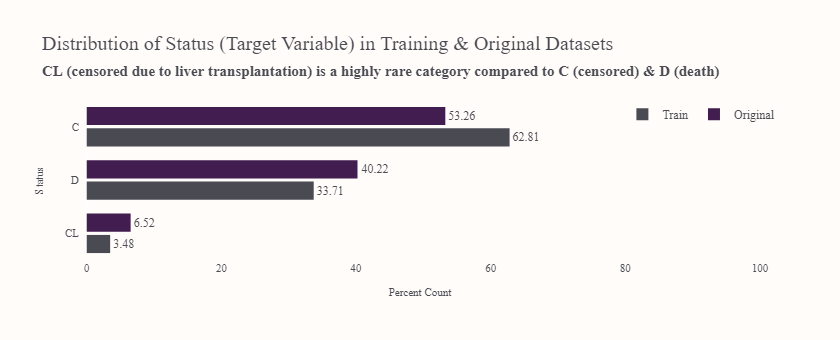

In [8]:
fig = px.histogram(
    train_extended,
    y="Status",
    histnorm="percent",
    color="Source",
    color_discrete_sequence=COLOR_SCHEME,
    width=840,
    height=340,
    barmode="group",
    text_auto="0.2f",  # type: ignore
    orientation="h",
    title="Distribution of Status (Target Variable) in Training & Original Datasets<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "CL (censored due to liver transplantation) is a highly rare category "
    "compared to C (censored) & D (death)</span>",
)
fig.update_yaxes(title="Status", categoryorder="total ascending")
fig.update_xaxes(title="Percent Count", range=(-1, 100))
fig.update_traces(textposition="outside")
fig.update_layout(bargap=0.2, bargroupgap=0.15, legend=dict(y=0.82, x=1.03, title=""))
save_and_show_fig(fig, "status_distribution")

In [9]:
print(CLR + "Original Dataset - General Summary:")
orig_summary = frame_summary(orig.drop(columns="Status"))
get_pretty_frame(orig_summary, gradient=True)

Original Dataset - General Summary:


,dtype,n_null,n_null_percent,n_unique,n_unique_percent,mode,mode_count,mode_percent_count
N_Days,int64,0,0.000,399,95.455,41,2,0.478
Drug,object,106,25.359,2,0.478,D-penicillamine,158,37.799
Age,int64,0,0.000,344,82.297,19724.000,7,1.675
Sex,object,0,0.000,2,0.478,F,374,89.474
Ascites,object,106,25.359,2,0.478,N,288,68.900
Hepatomegaly,object,106,25.359,2,0.478,Y,160,38.278
Spiders,object,106,25.359,2,0.478,N,222,53.110
Edema,object,0,0.000,3,0.718,N,354,84.689
Bilirubin,float64,0,0.000,98,23.445,0.700,33,7.895
Cholesterol,float64,134,32.057,201,48.086,260.000,4,0.957


In [10]:
print(CLR + "Training Dataset - General Summary:")
train_summary = frame_summary(train.drop(columns="Status"))
get_pretty_frame(train_summary, gradient=True)

Training Dataset - General Summary:


,dtype,n_null,n_null_percent,n_unique,n_unique_percent,mode,mode_count,mode_percent_count
N_Days,int64,0,0.000,461,5.832,1216,117,1.480
Drug,object,0,0.000,2,0.025,Placebo,4010,50.727
Age,int64,0,0.000,391,4.946,22369,79,0.999
Sex,object,0,0.000,2,0.025,F,7336,92.802
Ascites,object,0,0.000,2,0.025,N,7525,95.193
Hepatomegaly,object,0,0.000,2,0.025,Y,4042,51.132
Spiders,object,0,0.000,2,0.025,N,5966,75.471
Edema,object,0,0.000,3,0.038,N,7161,90.588
Bilirubin,float64,0,0.000,111,1.404,0.600,847,10.715
Cholesterol,float64,0,0.000,226,2.859,448.000,152,1.923


In [11]:
print(CLR + "Test Dataset - General Summary:")
test_summary = frame_summary(test)
get_pretty_frame(test_summary, gradient=True)

Test Dataset - General Summary:


,dtype,n_null,n_null_percent,n_unique,n_unique_percent,mode,mode_count,mode_percent_count
N_Days,int64,0,0.000,409,7.759,1216.000,82,1.556
Drug,object,0,0.000,2,0.038,Placebo,2694,51.110
Age,int64,0,0.000,363,6.887,19060,47,0.892
Sex,object,0,0.000,2,0.038,F,4877,92.525
Ascites,object,0,0.000,2,0.038,N,5027,95.371
Hepatomegaly,object,0,0.000,2,0.038,Y,2730,51.793
Spiders,object,0,0.000,2,0.038,N,3972,75.356
Edema,object,0,0.000,3,0.057,N,4786,90.799
Bilirubin,float64,0,0.000,108,2.049,0.600,609,11.554
Cholesterol,float64,0,0.000,222,4.212,248.000,91,1.726


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Missing &amp; Unique &amp; Most Frequent Values</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    <b>What's surprising about train & test dataset, there is no missing values, so we don't need to bother about imputation. On the other, hand these are present in the original dataset.</b> However, most of missing values there are related to certain group of patients as we read in the description, so perhaps we can use only the subset where all features' values are available. As we can see, there is a low diversity of values in train & test (as usual when datasets are generated artificially) and these datasets overlap. Apart from that, notice that the disease is mainly related to women here (about 90% are women). <a href="https://health.clevelandclinic.org/why-women-who-dont-drink-can-still-get-cirrhosis"><b>Here</b></a> you can read that: <i>"...This is primarily because more underlying liver and autoimmune diseases — as well as specific medicine or drug-related issues — affect more women than men..."</i>. But still, the 9:1 ratio is puzzling.<br><br>
    <code>Stage</code> should be categorical but it appears as a float point number. Let's change this so there won't be a mismatch on categorical/numerical plots.
</p>

In [12]:
train.Stage = train.Stage.astype("category")
test.Stage = test.Stage.astype("category")
orig.Stage = orig.Stage.astype("category")

In [13]:
print(CLR + "Original Dataset - Numerical Summary:")
orig_num_descr = numeric_descr(orig)
get_pretty_frame(orig_num_descr, gradient=True)

Original Dataset - Numerical Summary:


,Mean,Std,Min,1%,5%,25%,50%,75%,95%,99%,Max
N_Days,1917.782,1104.673,41.000,72.020,245.100,1092.750,1730.000,2613.500,4040.650,4494.390,4795.000
Age,18533.352,3815.845,9598.000,11185.020,12359.700,15644.500,18628.000,21272.500,24808.100,27111.200,28650.000
Bilirubin,3.221,4.408,0.300,0.400,0.500,0.800,1.400,3.400,14.000,21.328,28.000
Cholesterol,369.511,231.945,120.000,146.110,188.450,249.500,309.500,400.000,674.000,1500.400,1775.000
Albumin,3.497,0.425,1.960,2.313,2.750,3.243,3.530,3.770,4.141,4.380,4.640
Copper,97.648,85.614,4.000,10.090,17.450,41.250,73.000,123.000,249.200,441.120,588.000
Alk_Phos,1982.656,2140.389,289.000,381.070,599.650,871.500,1259.000,1980.000,6669.950,11290.104,13862.400
SGOT,122.556,56.700,26.350,43.400,54.250,80.600,114.700,151.900,219.247,297.923,457.250
Tryglicerides,124.702,65.149,33.000,45.620,56.000,84.250,108.000,151.000,230.950,333.400,598.000
Platelets,257.025,98.326,62.000,79.060,114.900,188.500,251.000,318.000,430.000,516.820,721.000


In [14]:
print(CLR + "Training Dataset - Numerical Summary:")
train_num_descr = numeric_descr(train)
get_pretty_frame(train_num_descr, gradient=True)

Training Dataset - Numerical Summary:


,Mean,Std,Min,1%,5%,25%,50%,75%,95%,99%,Max
N_Days,2030.173,1094.234,41.000,110.000,334.000,1230.000,1831.000,2689.000,4127.000,4509.000,4795.000
Age,18373.146,3679.959,9598.000,11167.000,12307.000,15574.000,18713.000,20684.000,24622.000,27220.000,28650.000
Bilirubin,2.594,3.813,0.300,0.400,0.500,0.700,1.100,3.000,11.000,20.000,28.000
Cholesterol,350.562,195.379,120.000,151.000,198.000,248.000,298.000,390.000,646.000,1276.000,1775.000
Albumin,3.548,0.346,1.960,2.430,2.970,3.350,3.580,3.770,4.080,4.300,4.640
Copper,83.903,75.899,4.000,10.000,14.000,39.000,63.000,102.000,231.000,412.000,588.000
Alk_Phos,1816.745,1903.751,289.000,378.480,614.000,834.000,1181.000,1857.000,6064.800,11036.552,13862.400
SGOT,114.605,48.791,26.350,45.000,54.250,75.950,108.500,137.950,198.400,272.294,457.250
Tryglicerides,115.340,52.530,33.000,50.000,56.000,84.000,104.000,139.000,210.000,309.000,598.000
Platelets,265.229,87.466,62.000,80.000,128.000,211.000,265.000,316.000,430.000,493.000,563.000


In [15]:
print(CLR + "Test Dataset - Numerical Summary:")
test_num_descr = numeric_descr(test)
get_pretty_frame(test_num_descr, gradient=True)

Test Dataset - Numerical Summary:


,Mean,Std,Min,1%,5%,25%,50%,75%,95%,99%,Max
N_Days,2038.697,1086.843,41.000,110.000,334.000,1234.000,1882.000,2692.000,4184.000,4509.000,4795.000
Age,18497.757,3583.899,9598.000,11273.000,12307.000,15730.000,18806.000,20684.000,24472.000,27220.000,28650.000
Bilirubin,2.600,3.852,0.300,0.400,0.500,0.700,1.100,3.000,9.950,20.000,28.000
Cholesterol,352.486,200.439,120.000,151.000,201.000,248.000,299.000,390.000,652.000,1336.000,1775.000
Albumin,3.538,0.355,1.960,2.430,2.940,3.350,3.570,3.770,4.090,4.300,4.640
Copper,84.702,77.542,4.000,11.000,15.000,39.000,65.000,102.000,231.000,444.000,588.000
Alk_Phos,1811.233,1935.351,289.000,420.300,614.000,823.000,1142.000,1838.500,6064.800,11046.600,13862.400
SGOT,113.588,48.965,26.350,43.400,54.250,75.000,106.950,137.950,198.400,272.800,457.250
Tryglicerides,115.286,52.603,33.000,49.000,56.000,84.000,104.000,138.000,210.000,309.000,598.000
Platelets,264.024,87.584,62.000,80.000,128.000,209.000,259.000,317.000,430.000,493.000,563.000


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Numerical Summary</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    So, as we can see, the original dataset is slightly different when you ask for distributions, but the train and test subsets almost perfectly overlap (see respective percentiles in both cases) for all attributes. It is most probable that they come from the same distribution.<br><br>
    Let's test the last consideration with <b>adversarial validation</b>. What is the adversarial validation? <b>Well, it's a very straightforward way to check whether our subsets are similar (sampled from the same or very similar distributions).</b> We label training and test datasets with, for example, $0$ and $1$. Then, we combine them into one dataset and shuffle them. Subsequently, we can perform binary classification and assess if we're able to identify which observation is from which dataset. When we get a ROC value of around $0.5$ (random guessing), they are indistinguishable, and this case is desired. On the other hand, when ROC $>0.5$, it probably means that training and test subsets are from different distributions.
</p>

In [16]:
train_av = train.drop(columns="Status").assign(AV=0)
test_av = test.assign(AV=1)

data_av = pd.concat((train_av, test_av), ignore_index=True)
data_av = data_av.sample(frac=1.0, random_state=42)

X = data_av.drop("AV", axis=1)
y = data_av.AV

y_proba = cross_val_predict(
    estimator=make_pipeline(
        make_column_transformer(
            (
                StandardScaler(),
                make_column_selector(dtype_include="number"),  # type: ignore
            ),
            (
                OneHotEncoder(handle_unknown="ignore"),
                make_column_selector(dtype_include=["object", "category"]),  # type: ignore
            ),
        ),
        LogisticRegression(random_state=42, penalty="l1", solver="liblinear"),
    ),
    X=X,
    y=y,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    method="predict_proba",
)

av_scores = {
    "ConfusionMatrix": confusion_matrix(y, y_proba.argmax(axis=1)),
    "FPR-TPR-Threshold": roc_curve(y, y_proba[:, 1]),
    "ROC-AUC": roc_auc_score(y, y_proba[:, 1]),
}

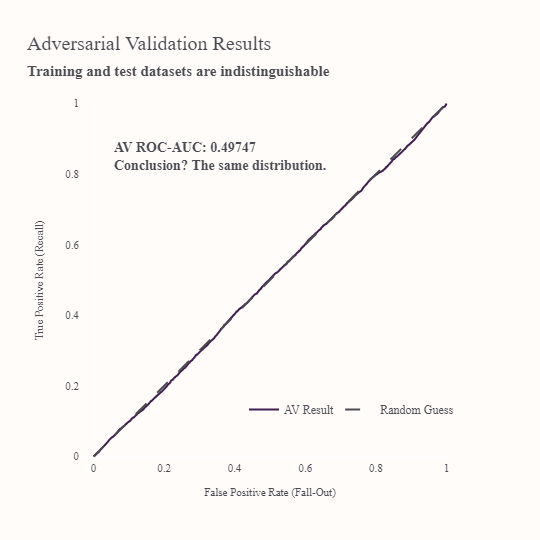

In [17]:
fig = go.Figure()
fig.add_scatter(
    x=av_scores["FPR-TPR-Threshold"][0],
    y=av_scores["FPR-TPR-Threshold"][1],
    name="AV Result",
    mode="lines",
    line_color=COLOR_SCHEME[1],
)
fig.add_scatter(
    x=[0, 1],
    y=[0, 1],
    name="Random Guess",
    mode="lines",
    line=dict(dash="longdash", color=COLOR_SCHEME[0]),
)
fig.add_annotation(
    x=0.05,
    y=0.85,
    align="left",
    xanchor="left",
    text=f"<b>AV ROC-AUC: {av_scores['ROC-AUC']:.5f}<br>" "Conclusion? The same distribution.",
    showarrow=False,
    font_size=14,
)
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
    range=(-0.01, 1.01),
    title="True Positive Rate (Recall)",
)
fig.update_xaxes(
    scaleanchor="y",
    scaleratio=1,
    range=(-0.01, 1.01),
    title="False Positive Rate (Fall-Out)",
)
fig.update_layout(
    title="Adversarial Validation Results<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Training and test datasets are indistinguishable</span>",
    width=540,
    legend=dict(y=0.1, x=1.0),
)
save_and_show_fig(fig, "adversarial_validation")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Adversarial Validation Results</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    So, the result is excellent for us since ROC $\approx 0.5$ means that subsets are indistinguishable (they come from the same distribution). Let's see histograms yet.
</p>

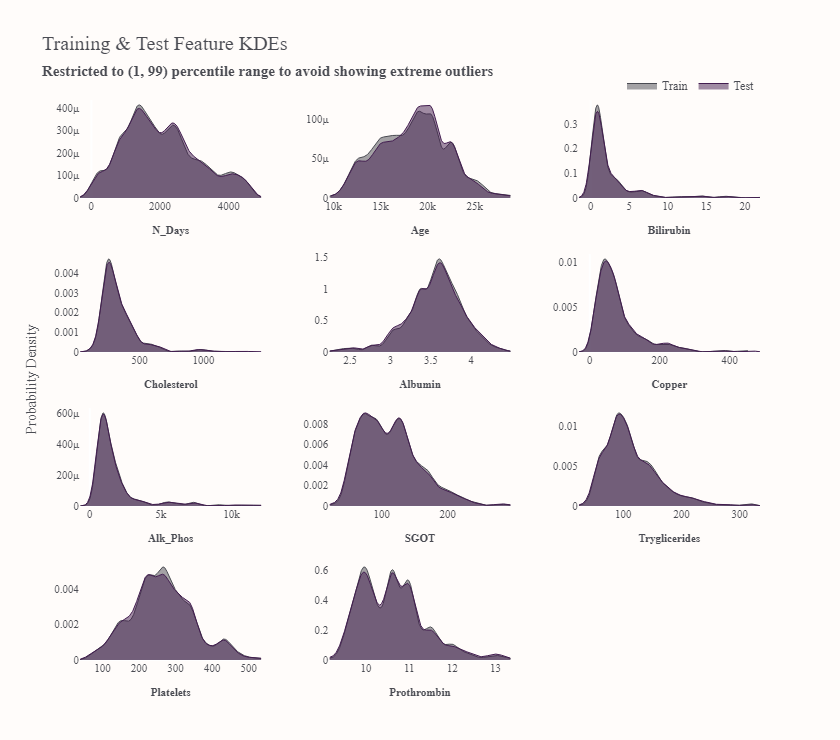

In [18]:
num_features = test.select_dtypes(include="number").columns.to_list()

n_cols = 3
n_rows, axes = get_n_rows_and_axes(len(num_features), n_cols)

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    y_title="Probability Density",
    horizontal_spacing=0.1,
    vertical_spacing=0.1,
).update_annotations(font_size=14)

for frame, color, group in zip((train, test), COLOR_SCHEME, ("Train", "Test")):
    for k, (var, (row, col)) in enumerate(zip(num_features, axes), start=1):
        kde = get_kde_estimation(frame[var], percentile_range=(1, 99))
        fig.add_scatter(
            x=kde["space"],
            y=kde["vals"],
            line=dict(dash="solid", color=color, width=1),
            fill="tozeroy",
            name=group,
            legendgroup=group,
            showlegend=k == 1,
            row=row,
            col=col,
        )
        fig.update_xaxes(title_text=f"<b>{var}</b>", row=row, col=col)

fig.update_layout(
    width=840,
    height=740,
    title="Training & Test Feature KDEs<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Restricted to (1, 99) percentile range to avoid showing extreme outliers</span>",
)
save_and_show_fig(fig, "kdes")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Continuous Feature Distributions</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Feature distributions confirm the previous statement, i.e. <b>training and test subsets probably follow the same distribution, which is reflected as  similar density estimation.</b> The original dataset is not shown here, but we already know it's slightly different. Let's continue analysis with cross tables.
</p>

In [19]:
crosstabs = []

for feature in num_features:
    cross = pd.crosstab(
        index=[pd.qcut(train[feature], q=5, duplicates="drop")],
        columns=train.Status,
        normalize="index",
    )
    stylish_frame = get_pretty_frame(cross, gradient=True, formatter="{:.1%}", repr_html=True)
    crosstabs.append(stylish_frame)

display_html(functools.reduce(operator.add, crosstabs[:3]), raw=True)

Status,C,CL,D
N_Days,,,
"(40.999, 1080.0]",18.2%,4.8%,76.9%
"(1080.0, 1569.0]",67.4%,5.8%,26.9%
"(1569.0, 2241.0]",76.8%,2.7%,20.4%
"(2241.0, 3050.0]",76.3%,2.8%,20.9%
"(3050.0, 4795.0]",75.9%,1.1%,23.0%
Status,C,CL,D
Age,,,
"(9597.999, 14899.0]",73.9%,6.8%,19.3%
"(14899.0, 17512.0]",64.2%,5.3%,30.5%


In [20]:
display_html(functools.reduce(operator.add, crosstabs[3:6]), raw=True)

Status,C,CL,D
Cholesterol,,,
"(119.999, 239.0]",66.6%,2.0%,31.4%
"(239.0, 273.0]",67.4%,2.3%,30.3%
"(273.0, 325.0]",77.4%,4.1%,18.5%
"(325.0, 414.0]",61.1%,3.8%,35.2%
"(414.0, 1775.0]",41.1%,5.3%,53.6%
Status,C,CL,D
Albumin,,,
"(1.959, 3.31]",35.6%,3.9%,60.4%
"(3.31, 3.5]",63.7%,3.2%,33.1%


In [21]:
display_html(functools.reduce(operator.add, crosstabs[6:9]), raw=True)

Status,C,CL,D
Alk_Phos,,,
"(288.999, 754.0]",77.0%,1.8%,21.2%
"(754.0, 1059.0]",67.4%,3.1%,29.5%
"(1059.0, 1403.0]",71.3%,5.4%,23.3%
"(1403.0, 2115.0]",55.0%,3.6%,41.4%
"(2115.0, 13862.4]",43.0%,3.6%,53.5%
Status,C,CL,D
SGOT,,,
"(26.349, 71.3]",84.6%,1.2%,14.2%
"(71.3, 93.0]",76.6%,1.5%,21.9%


In [22]:
display_html(functools.reduce(operator.add, crosstabs[9:]), raw=True)

Status,C,CL,D
Platelets,,,
"(61.999, 198.0]",44.5%,2.6%,52.9%
"(198.0, 238.0]",57.3%,3.1%,39.6%
"(238.0, 277.0]",70.4%,3.1%,26.5%
"(277.0, 335.0]",73.7%,5.1%,21.2%
"(335.0, 563.0]",68.3%,3.4%,28.3%
Status,C,CL,D
Prothrombin,,,
"(8.999, 9.9]",80.9%,2.9%,16.2%
"(9.9, 10.3]",72.9%,5.3%,21.7%


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Continuous Feature Cross Tables</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Here we create cross tables of each numerical feature versus the target variable. This gives us a handy univariate analysis of cut-off levels in particular variables and how target categories characterize this level. Each level is row-wise normalized, so for example, the $(0.299, 0.6]$ cut-off level in the <code>Bilirubin</code> feature is characterized by 90.44% observations with <code>C</code> target value. Here we have quite a lot of information, so I don't want to focus on each table but pay attention to <code>Bilirubin</code> and <code>Copper</code> variables. Something tells me that these can be important thereafter.
</p>

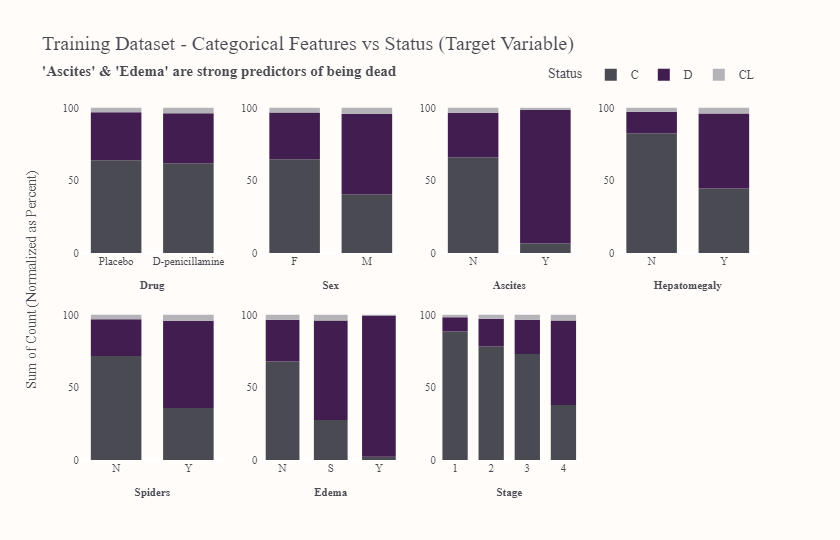

In [23]:
cat_features = test.select_dtypes(exclude="number").columns.to_list()

n_cols = 4
n_rows, axes = get_n_rows_and_axes(len(cat_features), n_cols)
fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    y_title="Sum of Count (Normalized as Percent)",
)
fig.update_annotations(font_size=14)

for k, (var, (row, col)) in enumerate(zip(cat_features, axes), start=1):
    for outcome, color in zip(("C", "D", "CL"), COLOR_SCHEME):
        fig.add_histogram(
            x=train.query(f"Status == '{outcome}'")[var],
            marker_color=color,
            name=outcome,
            legendgroup=outcome,
            showlegend=k == 1,
            row=row,
            col=col,
        )
        fig.update_xaxes(title_text=f"<b>{var}</b>", row=row, col=col)

fig.update_layout(
    title="Training Dataset - Categorical Features vs Status (Target Variable)<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "'Ascites' & 'Edema' are strong predictors of being dead</span>",
    width=840,
    height=540,
    barnorm="percent",
    barmode="relative",
    bargap=0.3,
    legend=dict(y=1.03, x=1, title="Status"),
)
save_and_show_fig(fig, "categorical_bars")

In [24]:
check_categories_alignment(train, test, out_color=MAGENTA)

The same categories in training and test datasets?

Drug                      True
Sex                       True
Ascites                   True
Hepatomegaly              True
Spiders                   True
Edema                     True
Stage                     True


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Categorical Feature Distributions</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Bar plots above are normalized as percent count so they can be easily compared across specific categories in the target variable. Let's see:
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    <li><code>Drug</code> - As long as it remains the only one feature, it says nothing since target distribution across its categories is almost equal.</li>
    <li><code>Ascites</code> & <code>Edema</code> - <b>Strong predictors of being dead.</b></li>
    <li><code>Stage</code> - As long as you increase the histologic stage of disease, then the probability of being dead rises too.</li>
</ul>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    An identical situation appears in the original dataset, and there is a high probability that in the test subset too. Let's get to the correlations!
</p>

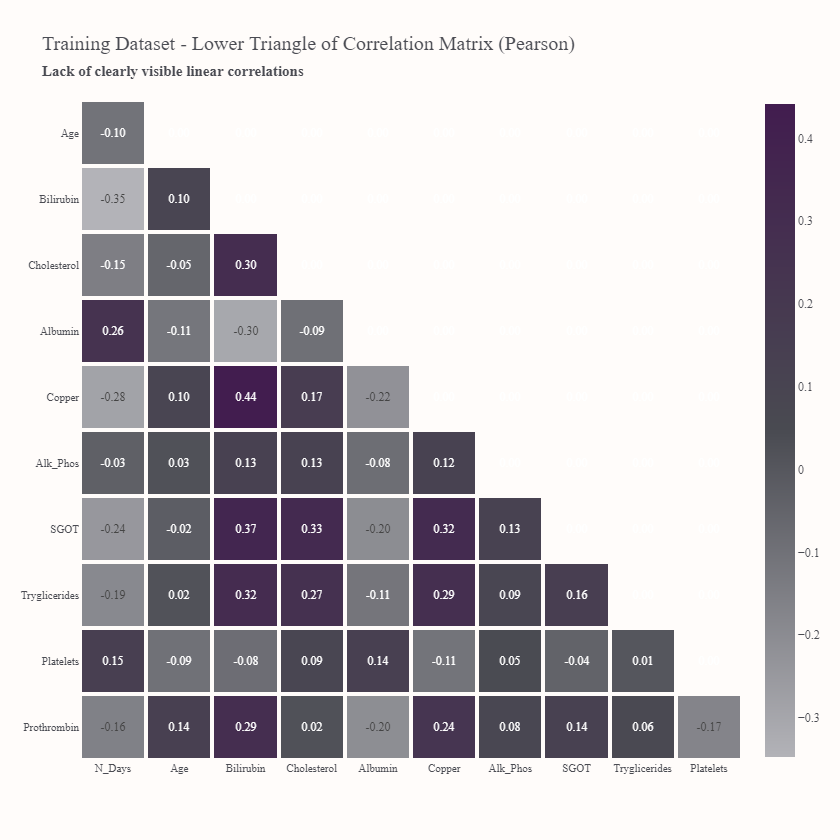

In [25]:
pearson_corr = train.corr(method="pearson", numeric_only=True)
lower_triu_corr = get_lower_triangular_frame(pearson_corr)
colormap = tuple(zip((0, 0.5, 1), COLOR_SCHEME[[2, 0, 1]]))

heatmap = go.Heatmap(
    z=lower_triu_corr,
    x=lower_triu_corr.columns,
    y=lower_triu_corr.index,
    text=lower_triu_corr.fillna(""),
    texttemplate="%{text:.2f}",
    xgap=4,
    ygap=4,
    showscale=True,
    colorscale=colormap,
    colorbar_len=1.02,
    hoverinfo="none",
)
fig = go.Figure(heatmap)
fig.update_layout(
    title="Training Dataset - Lower Triangle of Correlation Matrix (Pearson)<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Lack of clearly visible linear correlations</span>",
    yaxis_autorange="reversed",
    width=840,
    height=840,
)
save_and_show_fig(fig, "pearson_corr_matrix")

In [26]:
abs_corr = (
    lower_triu_corr.abs()
    .unstack()
    .sort_values(ascending=False)  # type: ignore
    .rename("Absolute Pearson Correlation")
    .to_frame()
    .reset_index(names=["Feature 1", "Feature 2"])
    .dropna()
    .round(5)
)

with pd.option_context("display.max_rows", 10):
    print(abs_corr)

        Feature 1      Feature 2  Absolute Pearson Correlation
0       Bilirubin         Copper                       0.44222
1       Bilirubin           SGOT                       0.36865
2          N_Days      Bilirubin                       0.34643
3     Cholesterol           SGOT                       0.32686
4          Copper           SGOT                       0.32323
..            ...            ...                           ...
50            Age       Alk_Phos                       0.02588
51    Cholesterol    Prothrombin                       0.02376
52            Age  Tryglicerides                       0.02177
53            Age           SGOT                       0.02077
54  Tryglicerides      Platelets                       0.00651

[55 rows x 3 columns]


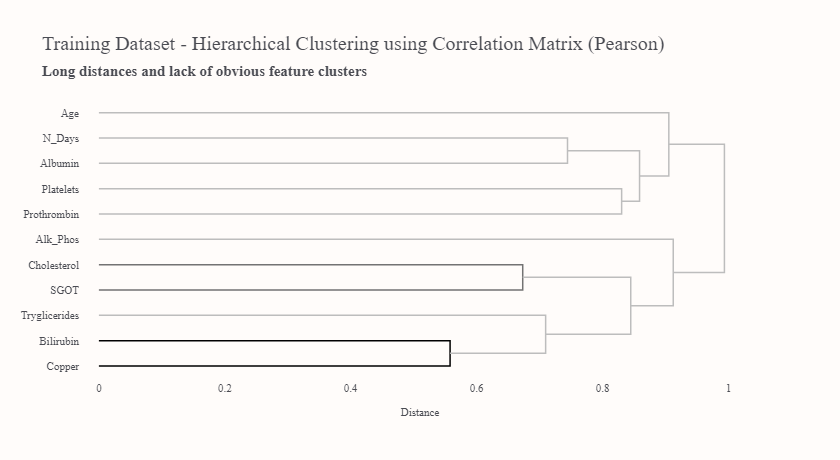

In [27]:
dissimilarity = 1 - np.abs(pearson_corr)

fig = ff.create_dendrogram(
    dissimilarity,
    labels=pearson_corr.columns,
    orientation="left",
    colorscale=px.colors.sequential.Greys[3:],
    # squareform() returns lower triangular in compressed form - as 1D array.
    linkagefun=lambda x: linkage(squareform(dissimilarity), method="complete"),
)
fig.update_xaxes(showline=False, title="Distance", ticks="", range=[-0.03, 1.05])
fig.update_yaxes(showline=False, ticks="")
fig.update_layout(
    title="Training Dataset - Hierarchical Clustering using Correlation Matrix (Pearson)<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Long distances and lack of obvious feature clusters</span>",
    height=460,
    width=840,
)
fig.update_traces(line_width=1.5, opacity=1)
save_and_show_fig(fig, "hierarchical_clustering")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Correlation Matrix &amp; Hierarchical Clustering</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    There we have Pearson correlation visual analysis. As you notice, there are no clear linear correlations. You can ask about the Spearman correlation, and perhaps we can talk about one correlated pair, i.e., <code>Copper</code> vs. <code>Bilirubin</code> ($0.59$). As for hierarchical clustering, it's based on linear correlations, which we just use to assess whether there are feature clusters. As you can see, unfortunately, we haven't got such here since distances between variables are quite large (it's just a reflection of weak correlations). In this specific example, I've used <code>complete</code> method in <code>linkage</code> function, and if you use a different method, you get different results.<br><br> Well, correlations don't tell us much. Maybe scatter-pair plots will show more?
</p>

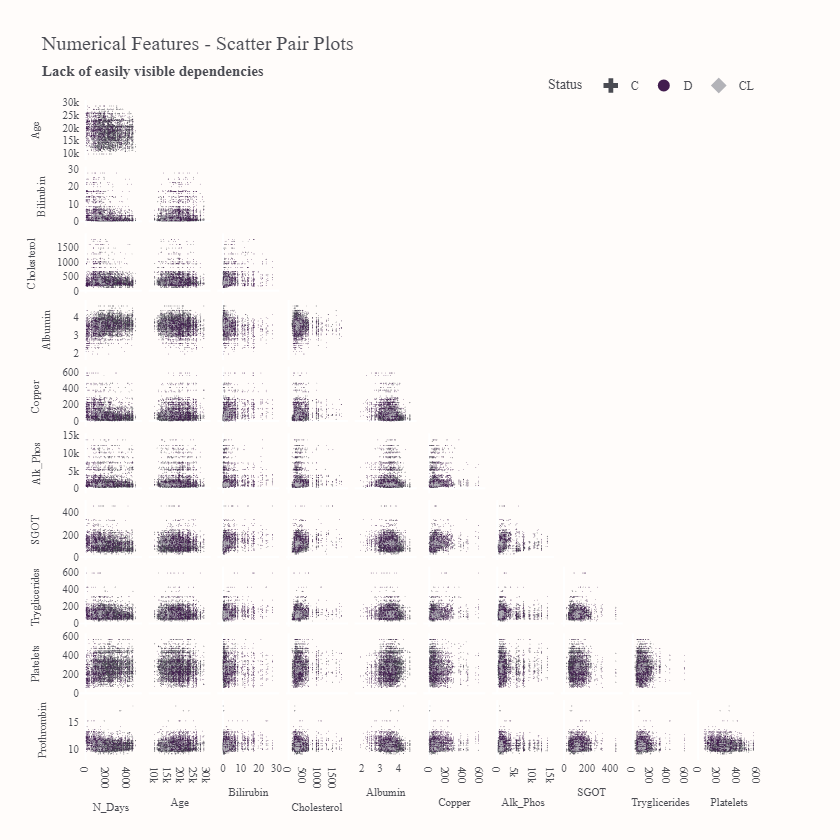

In [28]:
fig = px.scatter_matrix(
    train,
    dimensions=num_features,
    color="Status",
    symbol="Status",
    symbol_sequence=("cross", "circle", "diamond"),
    category_orders={"Status": ("C", "D", "CL")},
    title="Numerical Features - Scatter Pair Plots<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Lack of easily visible dependencies</span>",
    width=840,
    height=840,
)
fig.update_traces(diagonal_visible=False, showupperhalf=False, marker_size=0.75)
fig.update_layout(legend=dict(itemsizing="constant", title="Status"))
save_and_show_fig(fig, "scatter_pair_plots")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Scatter-Pair Plots</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    So, at first sight, there are no clear dependencies between target variables and the other features. Many samples overlap, and we can notice some linear patterns. These weird quantized values are probably the result of artificially generated data. There are no such patterns in the original dataset's scatter-pair plots.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.3</span> <span style='color: #421D4F'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Probability Plots &amp; Example Transformations</span></b><a class="anchor" id="probability_plots_and_example_transformations"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    This subsection focuses on the exploration of probability plots, which are a graphical technique used to determine if a variable adheres to a particular distribution, specifically the normal distribution in this case. <b>Probability plots display samples that follow a normal distribution along a straight diagonal line.</b> Some machine learning models make the assumption that variables follow a normal distribution. Consequently, the mentioned technique assists in determining the necessary transformations to improve the variable's alignment with that distribution. We will begin with examining the original values and observing the outcomes.
</p>

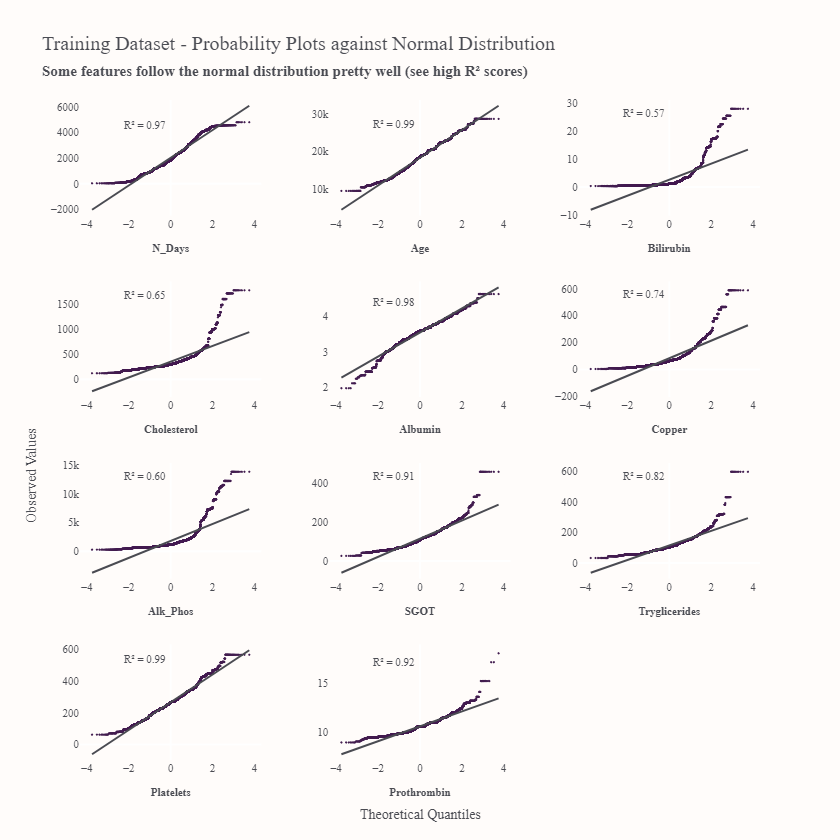

In [29]:
n_cols = 3
n_rows, axes = get_n_rows_and_axes(len(num_features), n_cols)

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    y_title="Observed Values",
    x_title="Theoretical Quantiles",
    horizontal_spacing=0.1,
    vertical_spacing=0.1,
)
fig.update_annotations(font_size=14, yshift=-45)

for (row, col), feature in zip(axes, num_features):
    (osm, osr), (slope, intercept, R) = stats.probplot(train[feature].dropna(), rvalue=True)
    x_theory = np.array([osm[0], osm[-1]])
    y_theory = intercept + slope * x_theory
    R2 = f"R\u00b2 = {R * R:.2f}"
    fig.add_scatter(x=osm, y=osr, mode="markers", row=row, col=col, name=feature)
    fig.add_scatter(x=x_theory, y=y_theory, mode="lines", row=row, col=col)
    fig.add_annotation(
        x=-1.25,
        y=osr[-1] * 0.95,
        text=R2,
        showarrow=False,
        row=row,
        col=col,
        font_size=11,
    )
    fig.update_xaxes(title_text=f"<b>{feature}</b>", row=row, col=col)

fig.update_layout(
    title="Training Dataset - Probability Plots against Normal Distribution<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Some features follow the normal distribution pretty well (see high R\u00b2 scores)</span>",
    width=840,
    height=840,
    showlegend=False,
)
fig.update_traces(
    marker=dict(size=1, symbol="x-thin", line=dict(width=2, color=COLOR_SCHEME[1])),
    line_color=COLOR_SCHEME[0],
)
save_and_show_fig(fig, "probability_plots")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Probability Plots against Normal Distribution</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    As you can see, some variables fit a normal distribution well, which manifests by a high coefficient of determination (R-squared) and evenly deployed samples around the straight line. However, there are same of features which have a poor fit. We can improve that through specific transformations. Mostly used transformations are log-level and square-root ones. These work fine with right-skewed data and help to reduce the impact of outliers. Another transformation is, for example, a reciprocal one, which is sometimes used when data is skewed, or there are obvious outliers. More sophisticated methods are Box-Cox transformation (requires strictly positive numbers) and Yeo-Johnson (variation of Box-Cox), which has no restrictions concerning numbers. We will check three of mentioned: log-level, square-root and Yeo-Johnson. For this case, we will utilise the <code>probplot</code> function from the <code>scipy</code> module to get R-squared coefficients as earlier.
</p>

In [30]:
features_to_improve = ("Bilirubin", "Cholesterol", "Copper", "Alk_Phos", "Tryglicerides")
r2_scores = {}

for feature in features_to_improve:
    feature_vals = train[feature].dropna()
    _, (*_, R_usual) = stats.probplot(feature_vals, rvalue=True)
    _, (*_, R_yeojohn) = stats.probplot(stats.yeojohnson(feature_vals)[0], rvalue=True)
    _, (*_, R_log) = stats.probplot(np.log1p(feature_vals), rvalue=True)
    _, (*_, R_sqrt) = stats.probplot(np.sqrt(feature_vals), rvalue=True)

    r2_scores[feature] = (
        R_usual * R_usual,
        R_yeojohn * R_yeojohn,
        R_log * R_log,
        R_sqrt * R_sqrt,
    )

r2_scores = pd.DataFrame(r2_scores, index=("Original", "YeoJohnson", "Log", "Sqrt")).transpose()
r2_scores["Winner"] = r2_scores.idxmax(axis=1)
get_pretty_frame(r2_scores)

,Original,YeoJohnson,Log,Sqrt,Winner
Bilirubin,0.566,0.938,0.830,0.763,YeoJohnson
Cholesterol,0.646,0.985,0.918,0.802,YeoJohnson
Copper,0.739,0.995,0.995,0.919,YeoJohnson
Alk_Phos,0.603,0.986,0.932,0.784,YeoJohnson
Tryglicerides,0.822,0.994,0.987,0.936,YeoJohnson


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>R-squared Scores within Some Transformations</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Well, as you can see <b>Yeo-Johnson's transformation wins in all cases and nicely improves fit to the normal distribution</b> ($R^2$ scores in all cases are above $0.90$). It's not a surprise for this type of transformation. 
</p>

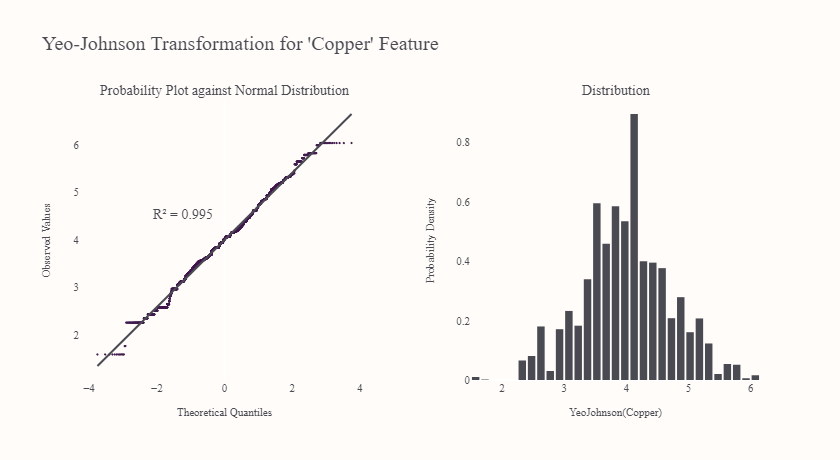

In [31]:
Copper_transformed = stats.yeojohnson(train.Copper.dropna())[0]
(osm, osr), (slope, intercept, R) = stats.probplot(Copper_transformed, rvalue=True)
x_theory = np.array([osm[0], osm[-1]])
y_theory = intercept + slope * x_theory

fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=["Probability Plot against Normal Distribution", "Distribution"],
    horizontal_spacing=0.15,
)

fig.add_scatter(x=osm, y=osr, mode="markers", row=1, col=1, name="YeoJohnson(Copper)")
fig.add_scatter(x=x_theory, y=y_theory, mode="lines", row=1, col=1)
fig.add_annotation(
    x=-1.25,
    y=osr[-1] * 0.75,
    text=f"R\u00b2 = {R * R:.3f}",
    showarrow=False,
    row=1,
    col=1,
)
fig.update_yaxes(title_text="Observed Values", row=1, col=1)
fig.update_xaxes(title_text="Theoretical Quantiles", row=1, col=1)
fig.update_traces(
    marker=dict(size=1, symbol="x-thin", line=dict(width=2, color=COLOR_SCHEME[1])),
    line_color=COLOR_SCHEME[0],
)

fig.add_histogram(
    x=Copper_transformed,
    xbins=go.histogram.XBins(size=0.15),
    marker_color=COLOR_SCHEME[0],
    name="YeoJohnson(Copper)",
    histnorm="probability density",
    row=1,
    col=2,
)
fig.update_yaxes(title_text="Probability Density", row=1, col=2)
fig.update_xaxes(title_text="YeoJohnson(Copper)", row=1, col=2)
fig.update_layout(
    title="Yeo-Johnson Transformation for 'Copper' Feature",
    showlegend=False,
    width=840,
    height=460,
    bargap=0.2,
)
fig.update_annotations(font_size=14)
save_and_show_fig(fig, "copper_after_transform")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Yeo-Johnson Transformation</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    It looks pretty well. We can include this type of transform in the preprocessing pipeline. Models like SVM and Linear Regression should be grateful.
</p>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2</span> <span style='color: #421D4F'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Unsupervised Learning &amp; Methods</span></b><a class="anchor" id="unsupervised_learning_and_methods"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>About Section</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In this section, we will see what can be done for this dataset in terms of unsupervised learning and how it can help in a further classification task.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.1</span> <span style='color: #421D4F'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Dimensionality Reduction via Different Algorithms</span></b><a class="anchor" id="dimensionality_reduction_via_different_algorithms"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Many exciting dimensionality reduction algorithms exist, like t-SNE, PCA or LLE. For example, the t-SNE method is an example of manifold learning and a great reduction technique commonly used for visualizing complex and high-dimensional data in a lower-dimensional space. It tries to preserve the original data structure, such that similar samples should be deployed close to each other in reduced dimensions. Using t-SNE, we should provide scaled data. Otherwise, specific dimensions can be dominated by features with larger scales or units. On the other hand, the PCA algorithm is a typical and probably the most straightforward one that tries to preserve as much variance as possible along principal components. <b>For the purpose of this notebook, we can test four techniques, i.e. PCA, Isomap, t-SNE and Gaussian Random Projection.</b>
</p>

In [32]:
preliminary_preprocess = make_column_transformer(
    (
        PowerTransformer(method="yeo-johnson", standardize=True),
        ("Bilirubin", "Cholesterol", "Copper", "Alk_Phos", "Tryglicerides"),
    ),
    (
        StandardScaler(),
        ("N_Days", "Age", "Albumin", "SGOT", "Platelets", "Prothrombin"),
    ),
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
        ("Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders"),
    ),
    (
        OneHotEncoder(handle_unknown="infrequent_if_exist", sparse_output=False),
        ("Edema", "Stage"),
    ),
).set_output(transform="pandas")

In [33]:
X = train.drop(columns="Status")
y = train.Status

X_processed = preliminary_preprocess.fit_transform(X)  # type: ignore
get_pretty_frame(X_processed.head())

,powertransformer__Bilirubin,powertransformer__Cholesterol,powertransformer__Copper,powertransformer__Alk_Phos,powertransformer__Tryglicerides,standardscaler__N_Days,standardscaler__Age,standardscaler__Albumin,standardscaler__SGOT,standardscaler__Platelets,standardscaler__Prothrombin,ordinalencoder__Drug,ordinalencoder__Sex,ordinalencoder__Ascites,ordinalencoder__Hepatomegaly,ordinalencoder__Spiders,onehotencoder__Edema_N,onehotencoder__Edema_S,onehotencoder__Edema_Y,onehotencoder__Stage_1.0,onehotencoder__Stage_2.0,onehotencoder__Stage_3.0,onehotencoder__Stage_4.0
id,,,,,,,,,,,,,,,,,,,,,,,
0,0.717,0.124,1.316,0.421,-1.390,-0.942,0.858,-0.573,1.336,1.472,-1.189,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000
1,-0.484,0.504,0.021,0.262,-0.443,0.497,0.235,-0.024,0.415,1.095,0.474,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000
2,1.071,-0.037,0.966,-0.301,-2.097,1.278,-1.263,0.005,0.097,-0.757,1.370,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000
3,-1.045,-0.528,-0.086,0.467,-0.210,0.499,0.024,-0.140,-0.888,0.043,0.090,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000
4,-0.206,0.373,0.021,-0.059,-0.210,-1.135,-0.466,0.294,0.224,0.375,-0.038,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000


In [34]:
rnd_projection2d = GaussianRandomProjection(n_components=2, random_state=42)
isomap2d = Isomap(n_components=2, n_neighbors=50, metric="mahalanobis")
tsne2d = TSNE(n_components=2, perplexity=50, metric="mahalanobis", random_state=42)
pca2d = KernelPCA(n_components=2, kernel="rbf", gamma=0.15, random_state=42)

rnd_projection2d_result = rnd_projection2d.fit_transform(X_processed)
isomap2d_result = isomap2d.fit_transform(X_processed)
tsne2d_result = tsne2d.fit_transform(X_processed)
pca2d_result = pca2d.fit_transform(X_processed)

rnd_projection2d_frame = pd.DataFrame(rnd_projection2d_result, columns=("x1", "x2")).join(y)
isomap2d_frame = pd.DataFrame(isomap2d_result, columns=("x1", "x2")).join(y)
tsne2d_frame = pd.DataFrame(tsne2d_result, columns=("x1", "x2")).join(y)
pca2d_frame = pd.DataFrame(pca2d_result, columns=("x1", "x2")).join(y)

rnd_projection2d_frame["Method"] = "GaussianRandomProjection"
isomap2d_frame["Method"] = "Isomap"
tsne2d_frame["Method"] = "TSNE"
pca2d_frame["Method"] = "PCA (RBF Kernel)"

result = pd.concat((rnd_projection2d_frame, isomap2d_frame, tsne2d_frame, pca2d_frame))

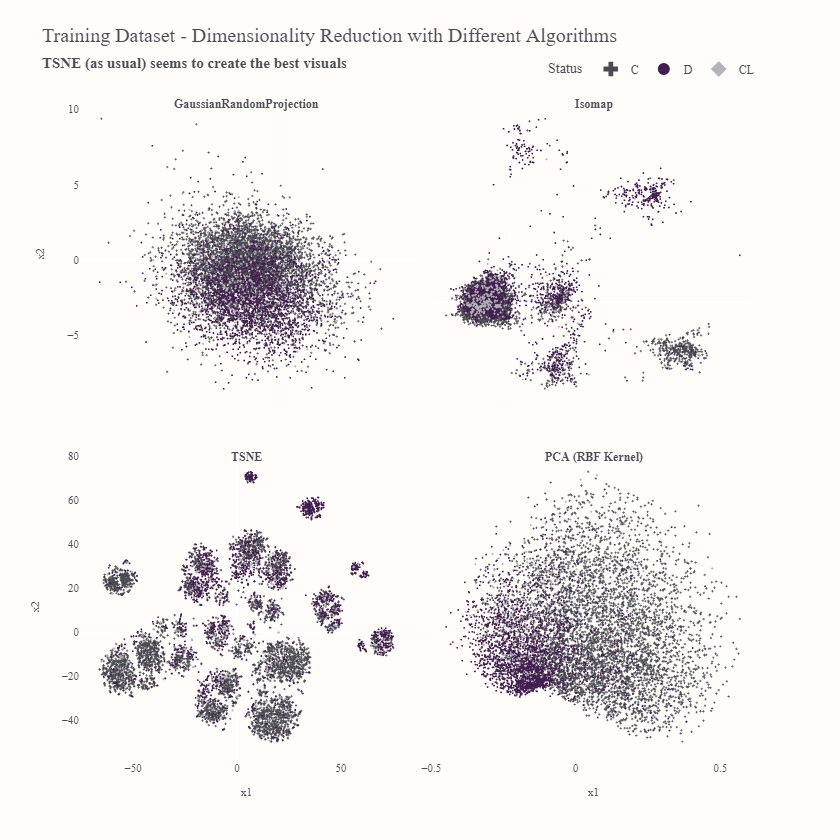

In [35]:
fig = px.scatter(
    result,
    x="x1",
    y="x2",
    color="Status",
    color_discrete_sequence=COLOR_SCHEME,
    symbol="Status",
    symbol_sequence=("cross", "circle", "diamond"),
    category_orders={"Status": ("C", "D", "CL")},
    facet_col="Method",
    facet_col_wrap=2,
    width=840,
    height=840,
    title="Training Dataset - Dimensionality Reduction with Different Algorithms<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "TSNE (as usual) seems to create the best visuals</span>",
)
fig.update_yaxes(matches=None)
fig.update_xaxes(matches=None)
fig.update_traces(marker_size=2)
fig.update_layout(legend=dict(y=1.025, x=1, itemsizing="constant", title="Status"), title_y=0.95)
fig.for_each_annotation(lambda a: a.update(text=f"<b>{a.text.split('=')[-1]}</b>", y=a.y - 0.02))
save_and_show_fig(fig, "projections_2d")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Dimensionality Reduction Results</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    As we can see, Gaussian Random Projection doesn't handle well in this particular case. Many samples overlap there. Isomap creates some clusters, but again, there is a similar problem as for Gaussian Projection. The t-SNE creates a pretty cool low-dimensional visual with many clusters with a significant prevalence of one class in some cases. Unfortunately, t-SNE is quite slow here. Kernel PCA with RBF kernel gives us something like a ball where one side is dominated by death cases and the second one by censored cases. Moreover, it's pretty fast. Let's focus on t-SNE and PCA with RBF kernel. Firstly, let's create a 3D visual via t-SNE.
</p>

In [36]:
tsne3d = TSNE(n_components=3, perplexity=50, metric="mahalanobis", random_state=42)
tsne3d_result = tsne3d.fit_transform(X_processed)
tsne3d_frame = pd.DataFrame(tsne3d_result, columns=("x1", "x2", "x3")).join(y)

In [37]:
fig = px.scatter_3d(
    tsne3d_frame,
    x="x1",
    y="x2",
    z="x3",
    color="Status",
    color_discrete_sequence=COLOR_SCHEME,
    symbol="Status",
    symbol_sequence=("cross", "circle", "diamond"),
    category_orders={"Status": ("C", "D", "CL")},
    opacity=0.75,
    height=840,
    width=840,
    title="Training Dataset - 3D Projection with t-SNE<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Many samples overlap, but we can easily see some mini-clusters where "
    "certain classes prevail</span>",
)
fig.update_traces(marker_size=2)
fig.update_layout(legend=dict(y=0.95, x=1, itemsizing="constant", title="Status"))
fig.show()

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Dimensionality Reduction with t-SNE</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    So, we see that t-SNE tried to separate samples by the target class. It looks pretty nice, but some clusters contain many examples from different classes. That could be related to artificially generated data. So, how can we use the fact that some samples can be separated well? <b>The t-SNE algorithm is too slow, but we can use Kernel PCA to reduce dimensionality and then utilize Nearest Neighbors to create features that reflect the probability of being a particular class.</b> This should work for censored and death cases but may pose a problem for censored due to transplantation cases. Nevertheless, it's worth trying.
</p>

In [38]:
class FeatureFromModel(
    MetaEstimatorMixin,  # Accepts any regressor
    BaseEstimator,  # `set_params()` and `get_params()`
    TransformerMixin,  # `fit_transform()`
    ClassNamePrefixFeaturesOutMixin,  # `get_feature_names_out()`
):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y):
        check_array(X)
        self.estimator_ = clone(self.estimator).fit(X, y)
        self.n_features_in_ = self.estimator_.n_features_in_
        self._n_features_out = len(np.unique(y))
        if hasattr(self.estimator, "feature_names_in_"):
            self.feature_names_in_ = self.estimator.feature_names_in_
        return self

    def transform(self, X):
        check_is_fitted(self)
        check_array(X)
        return self.estimator_.predict_proba(X)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Feature From Model</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    <code>FeatureFromModel</code> estimator will add new features from KNN, which reflects the probability of being a specific class based on nearest neighbours in 2D space.
</p>

In [39]:
knn_features = make_pipeline(
    preliminary_preprocess,
    KernelPCA(n_components=2, kernel="rbf", gamma=0.15, random_state=42),
    FeatureFromModel(KNeighborsClassifier(n_neighbors=101, weights="uniform")),
)

label_encoder = LabelEncoder()
X = train.drop(columns="Status")
y = label_encoder.fit_transform(train.Status)

knn_features.fit_transform(X, y)  # type: ignore

array([[0.35643564, 0.06930693, 0.57425743],
       [0.92079208, 0.02970297, 0.04950495],
       [0.22772277, 0.01980198, 0.75247525],
       ...,
       [0.14851485, 0.00990099, 0.84158416],
       [0.81188119, 0.        , 0.18811881],
       [0.96039604, 0.01980198, 0.01980198]])

In [40]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_oof_proba = np.zeros((len(y), len(np.unique(y))), dtype=np.float32)  # type: ignore

for fold, (train_ids, valid_ids) in enumerate(skf.split(X, y), start=1):
    X_train, y_train = X.iloc[train_ids], y[train_ids]  # type: ignore
    X_valid, y_valid = X.iloc[valid_ids], y[valid_ids]  # type: ignore

    knn_features.fit(X_train, y_train)  # type: ignore
    y_oof_proba[valid_ids] = knn_features.transform(X_valid)

print(CLR + "OOF Log Loss:", f"{MAGENTA}{log_loss(y, y_oof_proba):.5f}")
print(CLR + "OOF Accuracy:", f"{MAGENTA}{accuracy_score(y, y_oof_proba.argmax(axis=1)):.5f}")

OOF Log Loss: 0.55108
OOF Accuracy: 0.79823


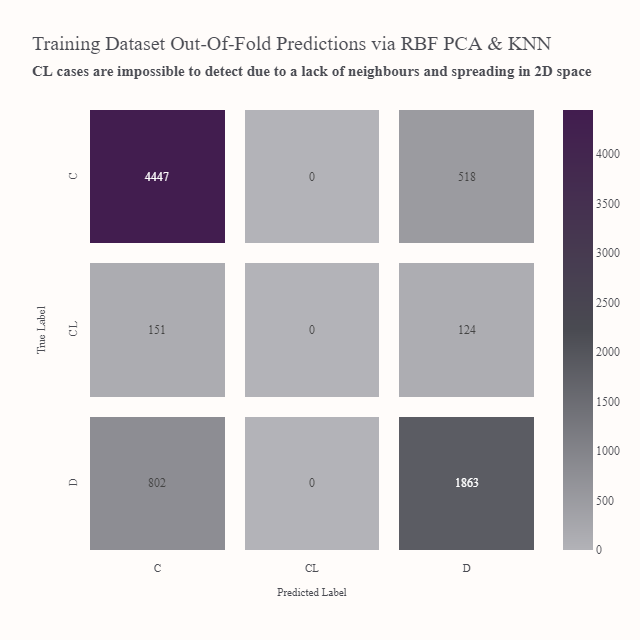

In [41]:
conf_matrix = confusion_matrix(y, y_oof_proba.argmax(axis=1))
classes = label_encoder.classes_
colormap = tuple(zip((0, 0.5, 1), COLOR_SCHEME[[2, 0, 1]]))

fig = go.Figure()
fig.add_heatmap(
    z=conf_matrix,
    x=classes,
    y=classes,
    name="ConfusionMatrix",
    text=conf_matrix,
    texttemplate="%{text}",
    xgap=20,
    ygap=20,
    showscale=True,
    colorscale=colormap,
)
fig.update_yaxes(title="True Label", autorange="reversed", tickangle=-90)
fig.update_xaxes(title="Predicted Label")
fig.update_layout(
    title="Training Dataset Out-Of-Fold Predictions via RBF PCA & KNN<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "CL cases are impossible to detect due to a lack of neighbours "
    "and spreading in 2D space</span>",
    height=640,
    width=640,
)
save_and_show_fig(fig, "rbf_pca_and_knn_confusion_matrix")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>RBF PCA Reduction &amp; KNN</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    So, here we are in a situation where our approach works quite well, but one problem arises. On the one hand, Kernel PCA and KNN work well in the case of two classes (C and D). However, this method doesn't handle CL cases. That's the result of rare occurrences of this class and lack of mini clusters, i.e. CL cases are spread out of the whole 2D space. The second problem is that the competition is <code>log_loss</code> scored, so this approach may introduce noise for CL examples and reflect a worse performance. I'll say more: KNN may boost the final classifier for C and D cases, but it's enough to make wrong decisions for CL examples to be severely punished in terms of <code>log_loss</code>.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.2</span> <span style='color: #421D4F'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">KMeans Clustering &amp; RBF Similarity</span></b><a class="anchor" id="kmeans_clustering_and_rbf_similarity"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In this subsection, we will focus on cluster analysis. We perform typical clustering with KMeans and compute some cluster centres. Subsequently, we will utilize the radial basis function (RBF) to calculate the similarity of each sample to the cluster centres.
</p>

In [42]:
class ClusterAffinity(
    BaseEstimator,  # `set_params()` and `get_params()`
    TransformerMixin,  # `fit_transform()`
    ClassNamePrefixFeaturesOutMixin,  # `get_feature_names_out()`
):
    def __init__(self, n_clusters=8, n_init=50, gamma=None, random_state=None):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        check_array(X)
        self.kmeans_ = KMeans(self.n_clusters, n_init=self.n_init, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        self.n_features_in_ = self.kmeans_.n_features_in_
        self.cluster_centers_ = self.kmeans_.cluster_centers_
        self._n_features_out = self.n_clusters
        if hasattr(self.kmeans_, "feature_names_in_"):
            self.feature_names_in_ = self.kmeans_.feature_names_in_
        return self

    def transform(self, X):
        check_is_fitted(self)
        check_array(X)
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Cluster Affinity</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    <code>ClusterAffinity</code> transformer will add new features using KMeans cluster centres that reflect similarities of each training sample to those centres using the RBF kernel.
</p>

In [43]:
cluster_affinity = ClusterAffinity(n_clusters=5, random_state=42)
similarities = cluster_affinity.fit_transform(X_processed)
similarities.round(3)[:3]

array([[0.508, 0.378, 0.442, 0.554, 0.519],
       [0.902, 0.711, 0.542, 0.645, 0.794],
       [0.432, 0.409, 0.503, 0.387, 0.441]])

In [44]:
train_cp = train.copy()
train_cp["Cluster"] = similarities.argmax(axis=1)
crosstab = pd.crosstab(index=train_cp.Cluster, columns=train_cp.Status, normalize="index")
get_pretty_frame(crosstab, formatter="{:.2%}", gradient=True)

Status,C,CL,D
Cluster,,,
0,82.23%,1.91%,15.87%
1,87.69%,0.90%,11.41%
2,15.98%,3.50%,80.52%
3,24.18%,5.97%,69.85%
4,73.57%,5.54%,20.89%


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Cluster Affinity</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The cross table above shows something like cluster impurity, i.e. how many samples of a specific target class belong to the given cluster. For example, we can see that 88% of samples in cluster 0 consist of C cases (censored). On the other hand, cluster 2 is dominated in 80% by D cases (death).
</p>

In [45]:
pca3d = KernelPCA(n_components=3, kernel="rbf", gamma=0.15, random_state=42)
pca2d_with_similarities = pd.DataFrame(
    pca3d.fit_transform(X_processed), columns=("x1", "x2", "x3")
)
pca2d_with_similarities["Cluster"] = similarities.argmax(axis=1).astype(str)
get_pretty_frame(pca2d_with_similarities.head())

,x1,x2,x3,Cluster
0,-0.134,-0.021,-0.040,3
1,0.139,0.235,-0.142,0
2,-0.119,-0.121,-0.058,2
3,0.391,0.161,0.031,0
4,-0.029,0.392,0.200,4


In [46]:
fig = px.scatter_3d(
    pca2d_with_similarities,
    x="x1",
    y="x2",
    z='x3',
    color="Cluster",
    color_discrete_sequence=COLOR_SCHEME,
    symbol="Cluster",
    category_orders={"Cluster": ("0", "1", "2", "3", "4")},
    opacity=0.75,
    height=840,
    width=840,
    title="Training Dataset - 3D Projection with RBF PCA & Clustering<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Some samples overlap, but clusters are clearly separable</span>",
)
fig.update_traces(marker_size=2)
fig.update_layout(legend=dict(y=0.95, x=1, itemsizing="constant", title="Cluster"))
fig.show()

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>KMeans Clusters in 3D</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    We can see that KMeans clusters are easily separable in 3D (using kernel PCA). We will include this step in the pipeline, but I don't think it will bring us any benefits in the log loss competition. 
</p>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">3</span> <span style='color: #421D4F'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Pipelines &amp; Optuna Tuning</span></b><a class="anchor" id="pipelines_and_optuna_tuning"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>About Section</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In this section, we will deal with composing preprocessing and feature engineering pipelines. Subsequently, I'll provide several useful mini-functions that you can use to fine-tune a model with the Optuna framework.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">3.1</span> <span style='color: #421D4F'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Pipelines in Feature Preprocess &amp; Engineering</span></b><a class="anchor" id="pipelines_in_feature_preprocess_and_engineering"></a> [↑](#top)

In [47]:
label_encoder = LabelEncoder()
X = train_extended.drop(columns="Status")
y = label_encoder.fit_transform(train_extended.Status)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Extended Training Dataset</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Here, I concatenate training and original datasets. It's the most straightforward approach, but we can also use the original subset in the training step only and validate the model on the subset from the training dataset. Subsequently, I encode classes with appropriate labels.
</p>

In [48]:
def deviation_from_average_cirrhosis_age(X, average_age):
    return (np.asarray(X) - average_age).reshape(-1, 1)


def beyond_normal_range(X, lower_limit, upper_limit):
    X = np.asarray(X)
    return ((X < lower_limit) | (X > upper_limit)).astype(np.float32)


def new_feature_name(function_transformer, feature_names_in, names):
    return names

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Some New Features</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    I've read somewhere that liver cirrhosis usually develops around the mean age of $52$. We can include a new feature which reflects a deviation from that number. For example, when the patient is $48$, then the deviation is $-4$. Next, we add binary features that denote when the medical indicator is beyond the normal range.
</p>

In [49]:
preliminary_preprocess = make_column_transformer(
    (
        PowerTransformer(method="yeo-johnson", standardize=True),
        ("Bilirubin", "Cholesterol", "Copper", "Alk_Phos", "Tryglicerides"),
    ),
    (
        StandardScaler(),
        ("N_Days", "Age", "Albumin", "SGOT", "Platelets", "Prothrombin"),
    ),
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
        ("Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders"),
    ),
    (
        OneHotEncoder(handle_unknown="infrequent_if_exist", sparse_output=False),
        ("Edema", "Stage"),
    ),
)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Preliminary Preprocess</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The preliminary preprocess provides a better fit to the normal distribution, scales the data and encodes appropriate categories. 
</p>

In [50]:
features_deviation = make_column_transformer(
    (
        make_pipeline(
            FunctionTransformer(
                beyond_normal_range,
                feature_names_out=functools.partial(
                    new_feature_name,
                    names=[
                        "beyond_normal_copper_range",
                        "beyond_normal_albumin_range",
                        "beyond_normal_bilirubin_range",
                        "beyond_normal_cholesterol_range",
                    ],
                ),
                kw_args=dict(
                    lower_limit=(62, 3.4, 0.2, 0),
                    upper_limit=(140, 5.4, 1.3, 240),
                ),
            )
        ),
        ("Copper", "Albumin", "Bilirubin", "Cholesterol"),
    ),
    (
        make_pipeline(
            FunctionTransformer(
                deviation_from_average_cirrhosis_age,
                feature_names_out=functools.partial(
                    new_feature_name, names=["deviation_from_average_cirrhosis_age"]
                ),
                kw_args=dict(average_age=52 * 365.25),
            ),
            StandardScaler(),
        ),
        ("Age",),
    ),
)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Features Deviation</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The features deviation pipeline will add new features that reflect when the specific indicator goes beyond the normal range. It also adds deviation from the mean age when the cirrhosis develops.
</p>

In [51]:
identity_transform = FunctionTransformer(feature_names_out="one-to-one")
cluster_affinity_features = ClusterAffinity(n_clusters=5, random_state=42)
knn_features = make_pipeline(
    KernelPCA(n_components=2, kernel="rbf", gamma=0.15, random_state=42),
    FeatureFromModel(KNeighborsClassifier(n_neighbors=101, weights="uniform")),
)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Cluster &amp; KNN Features</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    These pipelines add features we were talking about in the previous section. Identity transformer provides that preprocessed features go further in the another pipeline. If you want to assemble the entire pipeline, which preprocesses features and adds new indicators and features from clustering & KNN, you can do something like the following. Preprocessing is done only once, which is required for the subsequent clustering & KNN pipeline. Here, the identity transformer just passes the processed features further. On the other hand, adding binary indicators goes by a separate path.
</p>

In [52]:
full_pipeline = make_union(
    make_pipeline(
        preliminary_preprocess,
        make_union(
            identity_transform,
            knn_features,
            cluster_affinity_features,
        ),
    ),
    features_deviation,
).set_output(transform="pandas")

full_pipeline

FeatureUnion(transformer_list=[('pipeline',
                                Pipeline(steps=[('columntransformer',
                                                 ColumnTransformer(transformers=[('powertransformer',
                                                                                  PowerTransformer(),
                                                                                  ('Bilirubin',
                                                                                   'Cholesterol',
                                                                                   'Copper',
                                                                                   'Alk_Phos',
                                                                                   'Tryglicerides')),
                                                                                 ('standardscaler',
                                                                                  StandardScaler(),
                                                                                  ('N_Days',
                                                                                   'Age',
                                                                                   'Albumin',
                                                                                   'SGOT',
                                                                                   'Platelets',
                                                                                   'Prothrombin')),
                                                                                 ('ordinalencoder',
                                                                                  OrdinalEncoder(handl...
                                                                ('pipeline-2',
                                                                 Pipeline(steps=[('functiontransformer',
                                                                                  FunctionTransformer(feature_names_out=functools.partial(<function new_feature_name at 0x0000027A1D8FB490>, names=['deviation_from_average_cirrhosis_age']),
                                                                                                      func=<function deviation_from_average_cirrhosis_age at 0x0000027A1D8FA9E0>,
                                                                                                      kw_args={'average_age': 18993.0})),
                                                                                 ('standardscaler',
                                                                                  StandardScaler())]),
                                                                 ('Age',))]))])

In [53]:
get_pretty_frame(full_pipeline.fit_transform(X, y).head())  # type: ignore

,pipeline__functiontransformer__powertransformer__Bilirubin,pipeline__functiontransformer__powertransformer__Cholesterol,pipeline__functiontransformer__powertransformer__Copper,pipeline__functiontransformer__powertransformer__Alk_Phos,pipeline__functiontransformer__powertransformer__Tryglicerides,pipeline__functiontransformer__standardscaler__N_Days,pipeline__functiontransformer__standardscaler__Age,pipeline__functiontransformer__standardscaler__Albumin,pipeline__functiontransformer__standardscaler__SGOT,pipeline__functiontransformer__standardscaler__Platelets,pipeline__functiontransformer__standardscaler__Prothrombin,pipeline__functiontransformer__ordinalencoder__Drug,pipeline__functiontransformer__ordinalencoder__Sex,pipeline__functiontransformer__ordinalencoder__Ascites,pipeline__functiontransformer__ordinalencoder__Hepatomegaly,pipeline__functiontransformer__ordinalencoder__Spiders,pipeline__functiontransformer__onehotencoder__Edema_N,pipeline__functiontransformer__onehotencoder__Edema_S,pipeline__functiontransformer__onehotencoder__Edema_Y,pipeline__functiontransformer__onehotencoder__Stage_1.0,pipeline__functiontransformer__onehotencoder__Stage_2.0,pipeline__functiontransformer__onehotencoder__Stage_3.0,pipeline__functiontransformer__onehotencoder__Stage_4.0,pipeline__pipeline__featurefrommodel0,pipeline__pipeline__featurefrommodel1,pipeline__pipeline__featurefrommodel2,pipeline__clusteraffinity__clusteraffinity0,pipeline__clusteraffinity__clusteraffinity1,pipeline__clusteraffinity__clusteraffinity2,pipeline__clusteraffinity__clusteraffinity3,pipeline__clusteraffinity__clusteraffinity4,columntransformer__pipeline-1__beyond_normal_copper_range,columntransformer__pipeline-1__beyond_normal_albumin_range,columntransformer__pipeline-1__beyond_normal_bilirubin_range,columntransformer__pipeline-1__beyond_normal_cholesterol_range,columntransformer__pipeline-2__deviation_from_average_cirrhosis_age
2464,1.761,1.374,-0.449,-0.517,0.874,-0.864,-0.143,0.726,0.879,-1.245,-0.801,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.347,0.119,0.535,0.468,0.654,0.419,0.404,0.679,1.000,0.000,1.000,1.000,-0.143
7286,-0.216,-0.010,-0.449,1.991,-0.445,2.258,0.611,-0.825,-0.029,-0.503,-0.042,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.634,0.030,0.337,0.406,0.546,0.494,0.664,0.424,1.000,1.000,0.000,1.000,0.611
3862,-0.840,-0.173,0.093,1.847,0.642,2.227,-1.462,0.611,2.110,-0.001,0.464,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.535,0.040,0.426,0.284,0.462,0.315,0.535,0.402,0.000,0.000,0.000,1.000,-1.462
6884,-1.564,-3.678,-1.907,-0.248,-0.571,0.507,0.007,-0.136,-1.330,0.786,1.223,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.772,0.000,0.228,0.225,0.268,0.493,0.376,0.106,1.000,0.000,0.000,0.000,0.007
4098,-0.840,-0.378,-1.076,-0.813,-1.165,2.266,1.359,-0.566,-0.604,-0.469,-0.421,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.901,0.000,0.099,0.315,0.493,0.727,0.610,0.251,1.000,1.000,0.000,1.000,1.359


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Full Pipeline</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    As you can see, everything works as it should. The obtained data frame contains processed features, variables from RBF PCA & KNN, features from clustering and new binary indicators. Unfortunately, clustering and KNN don't give us a performance boost and are slightly computationally demanding, so we only assemble a pipeline like the one below.
</p>

In [54]:
preprocess_and_deviations = make_union(preliminary_preprocess, features_deviation).set_output(transform="pandas")
preprocess_and_deviations

FeatureUnion(transformer_list=[('columntransformer-1',
                                ColumnTransformer(transformers=[('powertransformer',
                                                                 PowerTransformer(),
                                                                 ('Bilirubin',
                                                                  'Cholesterol',
                                                                  'Copper',
                                                                  'Alk_Phos',
                                                                  'Tryglicerides')),
                                                                ('standardscaler',
                                                                 StandardScaler(),
                                                                 ('N_Days',
                                                                  'Age',
                                                                  'Albumin',
                                                                  'SGOT',
                                                                  'Platelets',
                                                                  'Prothrombin')),
                                                                ('ordinalencoder',
                                                                 OrdinalEncoder(handle_unknown='use_encoded_val...
                                                                ('pipeline-2',
                                                                 Pipeline(steps=[('functiontransformer',
                                                                                  FunctionTransformer(feature_names_out=functools.partial(<function new_feature_name at 0x0000027A1D8FB490>, names=['deviation_from_average_cirrhosis_age']),
                                                                                                      func=<function deviation_from_average_cirrhosis_age at 0x0000027A1D8FA9E0>,
                                                                                                      kw_args={'average_age': 18993.0})),
                                                                                 ('standardscaler',
                                                                                  StandardScaler())]),
                                                                 ('Age',))]))])

In [55]:
get_pretty_frame(preprocess_and_deviations.fit_transform(X).head())  # type: ignore

,columntransformer-1__powertransformer__Bilirubin,columntransformer-1__powertransformer__Cholesterol,columntransformer-1__powertransformer__Copper,columntransformer-1__powertransformer__Alk_Phos,columntransformer-1__powertransformer__Tryglicerides,columntransformer-1__standardscaler__N_Days,columntransformer-1__standardscaler__Age,columntransformer-1__standardscaler__Albumin,columntransformer-1__standardscaler__SGOT,columntransformer-1__standardscaler__Platelets,columntransformer-1__standardscaler__Prothrombin,columntransformer-1__ordinalencoder__Drug,columntransformer-1__ordinalencoder__Sex,columntransformer-1__ordinalencoder__Ascites,columntransformer-1__ordinalencoder__Hepatomegaly,columntransformer-1__ordinalencoder__Spiders,columntransformer-1__onehotencoder__Edema_N,columntransformer-1__onehotencoder__Edema_S,columntransformer-1__onehotencoder__Edema_Y,columntransformer-1__onehotencoder__Stage_1.0,columntransformer-1__onehotencoder__Stage_2.0,columntransformer-1__onehotencoder__Stage_3.0,columntransformer-1__onehotencoder__Stage_4.0,columntransformer-2__pipeline-1__beyond_normal_copper_range,columntransformer-2__pipeline-1__beyond_normal_albumin_range,columntransformer-2__pipeline-1__beyond_normal_bilirubin_range,columntransformer-2__pipeline-1__beyond_normal_cholesterol_range,columntransformer-2__pipeline-2__deviation_from_average_cirrhosis_age
2464,1.761,1.374,-0.449,-0.517,0.874,-0.864,-0.143,0.726,0.879,-1.245,-0.801,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000,-0.143
7286,-0.216,-0.010,-0.449,1.991,-0.445,2.258,0.611,-0.825,-0.029,-0.503,-0.042,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,1.000,0.611
3862,-0.840,-0.173,0.093,1.847,0.642,2.227,-1.462,0.611,2.110,-0.001,0.464,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,-1.462
6884,-1.564,-3.678,-1.907,-0.248,-0.571,0.507,0.007,-0.136,-1.330,0.786,1.223,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.007
4098,-0.840,-0.378,-1.076,-0.813,-1.165,2.266,1.359,-0.566,-0.604,-0.469,-0.421,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,1.000,1.359


## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">3.2</span> <span style='color: #421D4F'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Optuna Tuning</span></b><a class="anchor" id="optuna_tuning"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Here, I provide some utility functions to build and optimise the whole model with the <code>Optuna</code> framework. <b>Functions are written so that you can adjust your preprocess and classifier to your needs.</b>  
</p>

In [56]:
def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        params = reprlib.repr(
            {key.split("__")[-1]: np.round(value, 5) for key, value in frozen_trial.params.items()}
        )
        print(
            f"{CLR}Optuna Trial: {MAGENTA}{frozen_trial.number:03} {CLR}- ",
            f"{CLR}Best Value: {MAGENTA}{frozen_trial.value:.5f}\n",
            f"{CLR}Params: {MAGENTA}{params}",
            sep="",
        )

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Logging Callback</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The <code>logging_callback()</code> function is liable for the restricted output of Optuna logging. It's not important here, but it doesn't allow to litter the whole output.
</p>

In [57]:
def define_model(trial, seed=None):
    # lgb_params = {
    #     "verbose": trial.suggest_categorical("verbose", [-1]),
    #     "random_state": trial.suggest_categorical("random_state", [seed or 42]),
    #     "n_estimators": trial.suggest_categorical("n_estimators", [1000]),
    #     "subsample_freq": trial.suggest_categorical("subsample_freq", [1]),
    #     "max_depth": trial.suggest_int("max_depth", 2, 5),
    #     "min_child_samples": trial.suggest_int("min_child_samples", 16, 128, step=8),
    #     "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.2),
    #     "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 10, log=True),
    #     "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10, log=True),
    #     "subsample ": trial.suggest_float("subsample", 0.2, 0.8, step=0.1),
    #     "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 0.6, step=0.1),
    # }
    # return LGBMClassifier(**lgb_params)
    xgb_params = {
        "random_state": trial.suggest_categorical("random_state", [seed or 42]),
        "n_estimators": trial.suggest_categorical("n_estimators", [1000]),
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.1, 20, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 10, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 0.8, step=0.1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 0.6, step=0.1),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.2, 0.6, step=0.1),
    }
    return XGBClassifier(**xgb_params)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Model Definition</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The <code>define_model()</code> function is responsible for model definition. It simply uses Optuna trial API to suggest some hyperparameters which should be searched for.
</p>

In [58]:
MIN_DELTA = 1e-4
STOPPING_ROUNDS = 30


def objective(trial, X, y, seed=None):
    seed = seed or 42
    model = define_model(trial, seed)
    y_proba = np.zeros((len(y), len(np.unique(y))), dtype=np.float32)
    skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    for fold, (train_ids, test_ids) in enumerate(skfold.split(X, y), start=1):
        X_train, y_train = X.iloc[train_ids], y[train_ids]  # type: ignore
        X_test, y_test = X.iloc[test_ids], y[test_ids]  # type: ignore
        X_train, X_valid, y_train, y_valid = train_test_split(
            X_train, y_train, test_size=0.15, stratify=y_train, random_state=seed
        )

        X_train = preprocess_and_deviations.fit_transform(X_train)  # type: ignore
        X_test = preprocess_and_deviations.transform(X_test)  # type: ignore
        X_valid = preprocess_and_deviations.transform(X_valid)  # type: ignore

        # LGBM
        # model.fit(
        #     X_train,
        #     y_train,
        #     eval_metric="multi_logloss",
        #     eval_set=[(X_valid, y_valid)],
        #     callbacks=[
        #         early_stopping(STOPPING_ROUNDS, verbose=False, min_delta=MIN_DELTA),
        #         # Weak performance of this. Maybe we shouldn't use it with cross-validation.
        #         # optuna.integration.LightGBMPruningCallback(trial, "multi_logloss"),
        #     ],
        # )

        # XGBoost
        model.fit(
            X_train,
            y_train,
            verbose=False,
            eval_set=[(X_valid, y_valid)],
            callbacks=[
                EarlyStopping(STOPPING_ROUNDS, metric_name="mlogloss", min_delta=MIN_DELTA)
            ],
        )

        y_proba[test_ids] = model.predict_proba(X_test)

    return log_loss(y, y_proba)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Objective</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    There we have the <code>objective()</code> function. Inside this function is the whole logic and result, which should be optimized. I simply use stratified cross-validation and evaluate the model on the validation data. Moreover, I provide early stopping and trials pruning, when these are not promising.
</p>

In [59]:
def seed_study(seed, X, y, n_trials=100, n_jobs=-1):
    sampler = optuna.samplers.TPESampler(seed=seed)
    pruner = optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=3)
    study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)
    study.optimize(
        functools.partial(objective, X=X, y=y, seed=seed),  # type: ignore
        n_trials=n_trials,
        callbacks=[logging_callback],
        n_jobs=n_jobs,
    )

    # best_model = LGBMClassifier(**study.best_params)
    best_model = XGBClassifier(**study.best_params)
    return best_model, study

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Optuna Study</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The <code>seed_study()</code> function conducts hyperparameters searching. We create a new <code>Optuna</code> study instance in order to find the best model using certain criteria. Next, the best model (its hyperparameters) is passed to the model constructor, and we get the final model. In addition, I retrieve some useful information about the study to see it later. Generally, this is the last function for hyperparameter searching. Now we can prepare seeds and directory to save the best models.
</p>

In [60]:
def search_for_best_model(X, y, seeds, models_path, n_trials=100, n_jobs=-1):
    model_study = collections.namedtuple("Study", ["best_model", "study"])
    models = collections.defaultdict(model_study)

    for seed in seeds:
        print(CLR + "Seed:", seed)
        best_model, study = seed_study(seed, X, y, n_trials=n_trials, n_jobs=n_jobs)
        models[seed] = model_study(best_model, study)
        model_name = f"best_xgb_seed_{seed:03}_{time.strftime('run_%Y_%m_%d_%H_%M_%S')}.pkl"
        joblib.dump(best_model, models_path / model_name)
        print()

    return models

In [61]:
warnings.simplefilter("ignore")  # `callbacks` in `fit` method is deprecated - xgb
optuna.logging.set_verbosity(optuna.logging.ERROR)
np.random.seed(42)

models_path = pathlib.Path(f"models/")
models_path.mkdir(parents=True, exist_ok=True)

n_seeds = 1
seeds = np.random.randint(0, 1000, size=n_seeds).tolist()

print(CLR + "● Status Optimization:\n")
models = search_for_best_model(X, y, seeds, models_path, n_trials=50)

● Status Optimization:

Seed: 102


Optuna Trial: 004 - Best Value: 0.46057
Params: {'colsample_bylevel': 0.4, 'colsample_bytree': 0.5, 'learning_rate': 0.41508, 'max_depth': 5, ...}
Optuna Trial: 011 - Best Value: 0.44560
Params: {'colsample_bylevel': 0.2, 'colsample_bytree': 0.5, 'learning_rate': 0.40673, 'max_depth': 4, ...}
Optuna Trial: 000 - Best Value: 0.44256
Params: {'colsample_bylevel': 0.4, 'colsample_bytree': 0.6, 'learning_rate': 0.2005, 'max_depth': 3, ...}
Optuna Trial: 003 - Best Value: 0.44060
Params: {'colsample_bylevel': 0.4, 'colsample_bytree': 0.5, 'learning_rate': 0.12053, 'max_depth': 4, ...}
Optuna Trial: 009 - Best Value: 0.44003
Params: {'colsample_bylevel': 0.2, 'colsample_bytree': 0.4, 'learning_rate': 0.23775, 'max_depth': 5, ...}
Optuna Trial: 018 - Best Value: 0.43637
Params: {'colsample_bylevel': 0.6, 'colsample_bytree': 0.2, 'learning_rate': 0.28305, 'max_depth': 5, ...}



<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #421D4F;
">
    <b>Optuna Results &amp; Seeds Averaging</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Now we put the whole logic to a single <code>search_for_best_model()</code> function and get the best models depending on the seed. We used <code>defaultdict</code> and <code>namedtuple</code>, which allow us to easily see results and trials. Models are stored in a dictionary, where the key is the seed used during training. <b>Obviously, here is only an example to show you how this works. The best model won't be found since I set only $100$ trials. Normally, we should set, for example, $3$ seeds and $1000$ trials.</b>
</p>

In [62]:
models[102].best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.6, colsample_bynode=None,
              colsample_bytree=0.2, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2830522159343043,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5.709329941752177, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=102, ...)

In [63]:
fig = optuna.visualization.plot_param_importances(models[102].study)
fig.update_annotations(font_size=14)
fig.update_layout(bargap=0.3, width=840, height=440, xaxis_range=(-0.02, 1.0), yaxis_title="")
fig.show()

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">3.3</span> <span style='color: #421D4F'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Best LGBM &amp; XGB</span></b><a class="anchor" id="best_lgbm_and_xgb"></a> [↑](#top)

In [64]:
# TODO:

In [65]:
lgb_optuna_warmup_params = {
    "objective": "multiclass",
    "verbose": -1,
    "random_state": 102,
    "n_estimators": 1000,
    "max_depth": 5,
    "learning_rate": 0.055,
    "min_child_samples": 32,
    "colsample_bytree": 0.1,
    "reg_alpha": 1.586,
    "reg_lambda": 0.661,
    "subsample": 0.8,
    "subsample_freq": 1,
}

xgb_optuna_warmup_params = {
    "objective": "multi:softprob",
    "random_state": 102,
    "n_estimators": 1000,
    "max_depth": 5,
    "learning_rate": 0.11526,
    "colsample_bylevel": 0.8,
    "colsample_bytree": 0.2,
    "min_child_weight": 0.9,
    "reg_alpha": 1.058,
    "reg_lambda": 0.618,
    "subsample": 0.8,
}

lgb = LGBMClassifier(**lgb_optuna_warmup_params)
xgb = XGBClassifier(**xgb_optuna_warmup_params)

In [66]:
y_proba = np.zeros((len(y), len(np.unique(y))), dtype=np.float32)  # type: ignore
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_ids, test_ids) in enumerate(skfold.split(X, y), start=1):
    X_train, y_train = X.iloc[train_ids], y[train_ids]  # type: ignore
    X_test, y_test = X.iloc[test_ids], y[test_ids]  # type: ignore
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=0.15, stratify=y_train, random_state=42
    )

    X_train = preprocess_and_deviations.fit_transform(X_train)  # type: ignore
    X_test = preprocess_and_deviations.transform(X_test)  # type: ignore
    X_valid = preprocess_and_deviations.transform(X_valid)  # type: ignore

    lgb.fit(
        X_train,
        y_train,
        eval_metric="multi_logloss",
        eval_set=[(X_valid, y_valid)],
        callbacks=[early_stopping(STOPPING_ROUNDS, verbose=False, min_delta=MIN_DELTA)],
    )
    xgb.fit(
        X_train,
        y_train,
        verbose=False,
        eval_set=[(X_valid, y_valid)],
        callbacks=[EarlyStopping(STOPPING_ROUNDS, metric_name="mlogloss", min_delta=MIN_DELTA)],
    )

    lgb_valid_logloss = log_loss(y_valid, lgb.predict_proba(X_valid))  # type: ignore
    lgb_test_logloss = log_loss(y_test, lgb.predict_proba(X_test))  # type: ignore
    xgb_valid_logloss = log_loss(y_valid, xgb.predict_proba(X_valid))
    xgb_test_logloss = log_loss(y_test, xgb.predict_proba(X_test))

    print(CLR + "Fold:", f"{MAGENTA}{fold:2d}")
    print(CLR + "LGB Best Iter:", f"{MAGENTA}{lgb.best_iteration_:3d}", end=" ")
    print(CLR + "- Valid Log Loss:", f"{MAGENTA}{lgb_valid_logloss:.5f}", end=" ")
    print(CLR + "- Test Log Loss:", f"{MAGENTA}{lgb_test_logloss:.5f}")
    print(CLR + "XGB Best Iter:", f"{MAGENTA}{xgb.best_iteration:3d}", end=" ")
    print(CLR + "- Valid Log Loss:", f"{MAGENTA}{xgb_valid_logloss:.5f}", end=" ")
    print(CLR + "- Test Log Loss:", f"{MAGENTA}{xgb_test_logloss:.5f}", end="\n\n")

    lgb_proba = lgb.predict_proba(X_test)
    xgb_proba = xgb.predict_proba(X_test)

    y_proba[test_ids] = (lgb_proba + xgb_proba) / 2

print(CLR + "OOF Log Loss:", f"{MAGENTA}{log_loss(y, y_proba):.5f}")

Fold:  1
LGB Best Iter: 356 - Valid Log Loss: 0.40584 - Test Log Loss: 0.45688
XGB Best Iter: 217 - Valid Log Loss: 0.40878 - Test Log Loss: 0.46116

Fold:  2
LGB Best Iter: 281 - Valid Log Loss: 0.43299 - Test Log Loss: 0.41199
XGB Best Iter: 148 - Valid Log Loss: 0.42766 - Test Log Loss: 0.40786

Fold:  3
LGB Best Iter: 304 - Valid Log Loss: 0.42820 - Test Log Loss: 0.41140
XGB Best Iter: 200 - Valid Log Loss: 0.42777 - Test Log Loss: 0.41482

Fold:  4
LGB Best Iter: 325 - Valid Log Loss: 0.42199 - Test Log Loss: 0.41803
XGB Best Iter: 148 - Valid Log Loss: 0.41813 - Test Log Loss: 0.42835

Fold:  5
LGB Best Iter: 287 - Valid Log Loss: 0.44658 - Test Log Loss: 0.40947
XGB Best Iter: 147 - Valid Log Loss: 0.44706 - Test Log Loss: 0.41071

OOF Log Loss: 0.42093


In [67]:
label_encoder = LabelEncoder()
X_train = train_extended.drop(columns="Status")
y_train = label_encoder.fit_transform(train_extended.Status)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.15, stratify=y_train, random_state=42
)

X_train = preprocess_and_deviations.fit_transform(X_train)  # type: ignore
X_valid = preprocess_and_deviations.transform(X_valid)  # type: ignore
X_test = preprocess_and_deviations.transform(test)  # type: ignore

lgb.fit(
    X_train,
    y_train,  # type: ignore
    eval_metric="multi_logloss",
    eval_set=[(X_valid, y_valid)],
    callbacks=[early_stopping(STOPPING_ROUNDS, verbose=False, min_delta=MIN_DELTA)],
)
xgb.fit(
    X_train,
    y_train,
    verbose=False,
    eval_set=[(X_valid, y_valid)],
    callbacks=[EarlyStopping(STOPPING_ROUNDS, metric_name="mlogloss", min_delta=MIN_DELTA)],
)

lgb_proba = lgb.predict_proba(X_test)
xgb_proba = xgb.predict_proba(X_test)
y_pred = (lgb_proba + xgb_proba) / 2

submission = pd.DataFrame(
    {
        "id": test.index,
        "Status_C": y_pred[:, 0],
        "Status_CL": y_pred[:, 1],
        "Status_D": y_pred[:, 2],
    }
).set_index("id")

submission.to_csv("submission.csv")
get_pretty_frame(submission.head(), precision=5)

,Status_C,Status_CL,Status_D
id,,,
7905,0.50625,0.01597,0.47778
7906,0.47385,0.34317,0.18298
7907,0.03246,0.01540,0.95214
7908,0.97673,0.00524,0.01803
7909,0.79486,0.06897,0.13617


In [68]:
# TODO:
# We will see what to do next!

# If you have any questions, suggestions or ideas, feel free to leave a comment.
# Thanks for reading and good luck!